Linear Classification Models

Part A1: Data Preparation

In [3]:
import torch
import torch.nn as nn # type: ignore
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import time
import torch.nn.functional as F

c:\Users\Sama\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:


# 1. Download MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

# 2. Extract data and labels
X_train_full = mnist_train.data.float() / 255.0  # normalize to [0,1]
y_train_full = mnist_train.targets

X_test = mnist_test.data.float() / 255.0
y_test = mnist_test.targets

# 3. Flatten images for linear models (28x28 -> 784)
X_train_flat = X_train_full.view(-1, 28*28)
X_test_flat = X_test.view(-1, 28*28)

# 3.5 Filter to only digits 0 and 1 for binary logistic regression
mask_train = (y_train_full == 0) | (y_train_full == 1)
mask_test = (y_test == 0) | (y_test == 1)

X_train_flat = X_train_flat[mask_train]
y_train_full = y_train_full[mask_train]
X_test_flat = X_test_flat[mask_test]
y_test = y_test[mask_test]

# 4. Stratified split into 60% train, 20% validation, 20% test
from sklearn.model_selection import train_test_split

    # First split: 80% train+val, 20% test
X_temp, X_test_split, y_temp, y_test_split = train_test_split(
    X_train_flat, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

    # Second split: from the 80% temp, take 75% for train and 25% for val
    # (0.25 × 0.8 = 0.2 total → gives you 60% train, 20% val, 20% test)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Replace test set with this split version
X_test_flat, y_test = X_test_split, y_test_split

X_train, X_val = X_temp, X_val
y_train, y_val = y_temp, y_val

# 5. Convert to PyTorch datasets and DataLoaders
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test_flat, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("Data preparation done!")
print(f"Train samples: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"Unique classes: {torch.unique(y_train)}")


Data preparation done!
Train samples: 10132 | Val: 2533 | Test: 2533
Unique classes: tensor([0, 1])


Part A2: Logistic Regression (Binary Classification, 0 vs 1)

In [5]:
# Select only digits 0 and 1 for binary classification
binary_train_idx = (y_train == 0) | (y_train == 1)
binary_val_idx = (y_val == 0) | (y_val == 1)
binary_test_idx = (y_test == 0) | (y_test == 1)

X_train_bin = X_train[binary_train_idx]
y_train_bin = y_train[binary_train_idx]
X_val_bin = X_val[binary_val_idx]
y_val_bin = y_val[binary_val_idx]
X_test_bin = X_test_flat[binary_test_idx]
y_test_bin = y_test[binary_test_idx]

# Convert to DataLoaders
train_loader_bin = DataLoader(TensorDataset(X_train_bin, y_train_bin), batch_size=64, shuffle=True)
val_loader_bin = DataLoader(TensorDataset(X_val_bin, y_val_bin), batch_size=64)
test_loader_bin = DataLoader(TensorDataset(X_test_bin, y_test_bin), batch_size=64)


Binary Logistic Regression (manual implementation)

In [6]:
# Model parameters
input_dim = 28 * 28
W = torch.zeros(input_dim, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Sigmoid activation
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

# Binary cross-entropy loss
def binary_cross_entropy(y_pred, y_true):
    y_true = y_true.view(-1, 1).float()
    eps = 1e-8
    return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))


Binary Logistic Regression: Training Loop with Early Stopping

In [7]:
import torch

def train_logistic_regression(train_loader, val_loader, learning_rate=0.01, max_epochs=100, patience=5):
    # --- Helper functions ---
    def sigmoid(x):
        return 1 / (1 + torch.exp(-x))

    def binary_cross_entropy(y_pred, y_true):
        eps = 1e-8 # to avoid log(0)
        return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))

    # --- Initialize weights ---
    W = torch.randn(784, 1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    final_epoch = 0
    final_train_loss = 0
    final_train_acc = 0
    final_val_loss = 0
    final_val_acc = 0

    # --- Training Loop ---
    for epoch in range(max_epochs):
        W.grad = None
        b.grad = None
        total_loss = 0
        correct = 0
        total = 0

        # --- Training ---
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.view(-1, 1).float()
            y_pred = sigmoid(X_batch @ W + b)
            loss = binary_cross_entropy(y_pred, y_batch)
            loss.backward() # compute gradients
            
            with torch.no_grad():
                W -= learning_rate * W.grad
                b -= learning_rate * b.grad

            W.grad.zero_()
            b.grad.zero_()

            total_loss += loss.item() * X_batch.size(0)
            preds = (y_pred > 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        # --- Validation ---
        with torch.no_grad():
            val_loss = 0
            correct_val = 0
            total_val = 0
            for X_batch, y_batch in val_loader:
                y_batch = y_batch.view(-1, 1).float()
                y_pred = sigmoid(X_batch @ W + b)
                val_loss += binary_cross_entropy(y_pred, y_batch).item() * X_batch.size(0)
                preds = (y_pred > 0.5).float()
                correct_val += (preds == y_batch).sum().item()
                total_val += y_batch.size(0)
            val_loss /= total_val
            val_acc = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # --- Early Stopping ---
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            epochs_no_improve = 0
            final_epoch = epoch + 1
            final_train_loss = train_loss
            final_train_acc = train_acc
            final_val_loss = val_loss
            final_val_acc = val_acc
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f" Converged (early stopping) at epoch {epoch+1} [LR={learning_rate}]")
            break

    else:
        final_epoch = max_epochs

    print(f"\nFinal Results (LR={learning_rate}, Epoch {final_epoch}):")
    print(f"Train Loss: {final_train_loss:.4f} | Train Acc: {final_train_acc:.4f}")
    print(f"Val Loss:   {final_val_loss:.4f} | Val Acc:   {final_val_acc:.4f}")

    return {
        "W": W,
        "b": b,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "final_train_acc": final_train_acc,
        "final_val_acc": final_val_acc,
        "final_epoch": final_epoch
    }


Binary Logistic Regression: Loss and Accuracy Curves


Final Results (LR=0.01, Epoch 100):
Train Loss: 0.0142 | Train Acc: 0.9970
Val Loss:   0.0194 | Val Acc:   0.9961


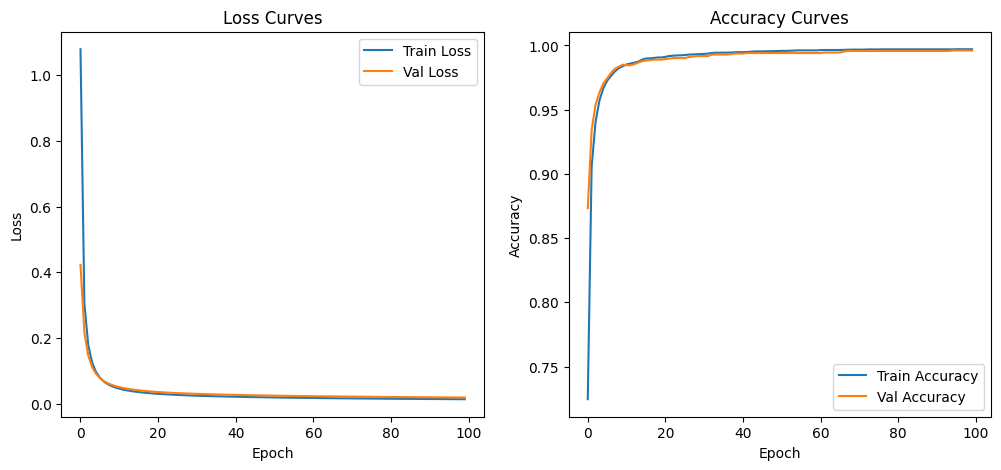

In [8]:
# --- Call training function ---
results = train_logistic_regression(train_loader, val_loader, learning_rate=0.01)

# --- Extract returned parameters ---
W = results["W"]
b = results["b"]
train_losses = results["train_losses"]
val_losses   = results["val_losses"]
train_accs   = results["train_accs"]
val_accs     = results["val_accs"]

# --- Plot Loss and Accuracy Curves ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


Binary Logistic Regression: Final Test Evaluation + Confusion Matrix


Final Test Accuracy: 0.9957


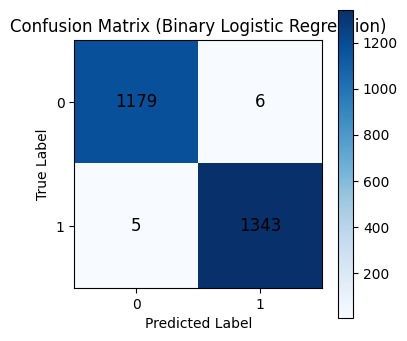

In [9]:
# --- Test Evaluation (Manual Confusion Matrix) ---

W.requires_grad = False
b.requires_grad = False

all_preds = []
all_labels = []

with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for X_batch, y_batch in test_loader:
        X_batch = X_batch.view(X_batch.size(0), -1)  # flatten
        y_batch = y_batch.view(-1).float()  # ensure same shape (N,)
        
        # Forward pass
        y_pred = sigmoid(X_batch @ W + b)
        preds = (y_pred > 0.5).float().view(-1)
        
        # Append batch results
        all_preds.append(preds)
        all_labels.append(y_batch)
        
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

# Combine all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Compute accuracy
test_acc = total_correct / total_samples
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

# --- Manual Confusion Matrix ---
num_classes = 2
cm = torch.zeros((num_classes, num_classes), dtype=torch.int32)

for t, p in zip(all_labels, all_preds):
    cm[int(t), int(p)] += 1

# print("\nConfusion Matrix (rows=True Labels, cols=Predicted Labels):")
# print(cm)

# --- Visualization ---
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Binary Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1])
plt.yticks([0, 1])

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f"{cm[i,j].item()}", ha='center', va='center', color='black', fontsize=12)

plt.colorbar()
plt.show()


In [10]:
# Save the trained Binary Logistic Regression model
# Create a wrapper class to make the manual W and b compatible with nn.Module
class LogisticRegressionModel(nn.Module):
    def __init__(self, W, b):
        super().__init__()
        self.W = nn.Parameter(W.detach().clone())
        self.b = nn.Parameter(b.detach().clone())
    
    def forward(self, x):
        return torch.sigmoid(x @ self.W + self.b)

# Save the trained model
logistic_model = LogisticRegressionModel(W, b)
print("✓ Binary Logistic Regression model saved as 'logistic_model'!")

✓ Binary Logistic Regression model saved as 'logistic_model'!


---------------------------------------------

A3: Softmax Regression Implementation

## Softmax Regression (Manual) 

Data Preperation

In [11]:

# 1. Load MNIST (10 classes)
mnist = datasets.MNIST(root='./data', train=True, download=True)
X_full = mnist.data.float().view(-1, 28*28) / 255.0
y_full = mnist.targets

# Combine train+test for a full dataset
mnist_test = datasets.MNIST(root='./data', train=False, download=True)
X_extra = mnist_test.data.float().view(-1, 28*28) / 255.0
y_extra = mnist_test.targets

X_all = torch.cat([X_full, X_extra], dim=0)
y_all = torch.cat([y_full, y_extra], dim=0)

# 2. Split 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)  # 0.25 * 0.8 = 0.2

# 3. Create DataLoaders
batch_size = 64
train_dataset_SM = TensorDataset(X_train, y_train)
val_dataset_SM = TensorDataset(X_val, y_val)
test_dataset_SM = TensorDataset(X_test, y_test)

train_loader_SM = DataLoader(train_dataset_SM, batch_size=batch_size, shuffle=True)
val_loader_SM = DataLoader(val_dataset_SM, batch_size=batch_size)
test_loader_SM = DataLoader(test_dataset_SM, batch_size=batch_size)

print(f"Train: {len(train_dataset_SM)} | Val: {len(val_dataset_SM)} | Test: {len(test_dataset_SM)}")
print(f"Unique classes: {torch.unique(y_train)}")


Train: 42000 | Val: 14000 | Test: 14000
Unique classes: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


Softmax Regression Manual

In [12]:
# --- Helper functions ---
def softmax(x):
    exp_x = torch.exp(x - torch.max(x, dim=1, keepdim=True).values)  # numerical stability
    return exp_x / exp_x.sum(dim=1, keepdim=True)

def cross_entropy_loss(y_pred, y_true):
    eps = 1e-8
    batch_size = y_pred.shape[0]
    correct_logprobs = -torch.log(y_pred[range(batch_size), y_true] + eps)
    return correct_logprobs.mean()

def accuracy(y_pred, y_true):
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().mean().item()


Softmax regression has:

W → shape [784, 10]

b → shape [10]

In [13]:
input_dim = 784
num_classes = 10

W = torch.randn(input_dim, num_classes, requires_grad=True)
b = torch.zeros(num_classes, requires_grad=True)

learning_rate = 0.01
max_epochs = 100
patience = 5


Softmax Regression Manual : Training Loop with Early Stopping

In [14]:
import torch

def train_softmax_regression(train_loader_SM, val_loader_SM, input_dim=784, num_classes=10, learning_rate=0.01, max_epochs=100, patience=5):
    """
    Train a softmax regression (multiclass logistic regression) model manually with early stopping.
    """

    # --- Helper functions ---
    def softmax(x):
        exp_x = torch.exp(x - torch.max(x, dim=1, keepdim=True).values)  # numerical stability
        return exp_x / torch.sum(exp_x, dim=1, keepdim=True)

    def cross_entropy_loss(y_pred, y_true):
        eps = 1e-8
        y_true_one_hot = torch.nn.functional.one_hot(y_true, num_classes=y_pred.shape[1]).float()
        return -torch.mean(torch.sum(y_true_one_hot * torch.log(y_pred + eps), dim=1))

    # --- Initialize weights ---
    W = torch.randn(input_dim, num_classes, requires_grad=True)
    b = torch.zeros(num_classes, requires_grad=True)

    # --- Tracking ---
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    final_epoch = 0
    final_train_loss = 0
    final_train_acc = 0
    final_val_loss = 0
    final_val_acc = 0

    # --- Training Loop ---
    for epoch in range(max_epochs):
        total_loss, correct, total = 0, 0, 0

        # --- Training ---
        for X_batch, y_batch in train_loader_SM:
            y_batch = y_batch.long()
            scores = X_batch @ W + b
            y_pred = softmax(scores)
            loss = cross_entropy_loss(y_pred, y_batch)
            loss.backward()

            with torch.no_grad():
                W -= learning_rate * W.grad
                b -= learning_rate * b.grad

            W.grad.zero_()
            b.grad.zero_()

            total_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(y_pred, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        # --- Validation ---
        with torch.no_grad():
            val_loss, correct_val, total_val = 0, 0, 0
            for X_batch, y_batch in val_loader_SM:
                y_batch = y_batch.long()
                scores = X_batch @ W + b
                y_pred = softmax(scores)
                val_loss += cross_entropy_loss(y_pred, y_batch).item() * X_batch.size(0)
                preds = torch.argmax(y_pred, dim=1)
                correct_val += (preds == y_batch).sum().item()
                total_val += y_batch.size(0)

            val_loss /= total_val
            val_acc = correct_val / total_val

        # Record metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # --- Early Stopping ---
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            epochs_no_improve = 0
            final_epoch = epoch + 1
            final_train_loss = train_loss
            final_train_acc = train_acc
            final_val_loss = val_loss
            final_val_acc = val_acc
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Converged (early stopping) at epoch {epoch+1} [LR={learning_rate}]")
            break

    else:
        final_epoch = max_epochs

    # --- Final Results ---
    print(f"\nFinal Results (LR={learning_rate}, Epoch {final_epoch}):")
    print(f"Train Loss: {final_train_loss:.4f} | Train Acc: {final_train_acc:.4f}")
    print(f"Val Loss:   {final_val_loss:.4f} | Val Acc:   {final_val_acc:.4f}")

    return {
        "W": W,
        "b": b,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "final_train_acc": final_train_acc,
        "final_val_acc": final_val_acc,
        "final_epoch": final_epoch
    }


Softmax Regression Manual: Loss and Accuracy Curves


Final Results (LR=0.01, Epoch 100):
Train Loss: 0.4944 | Train Acc: 0.8861
Val Loss:   0.5089 | Val Acc:   0.8811


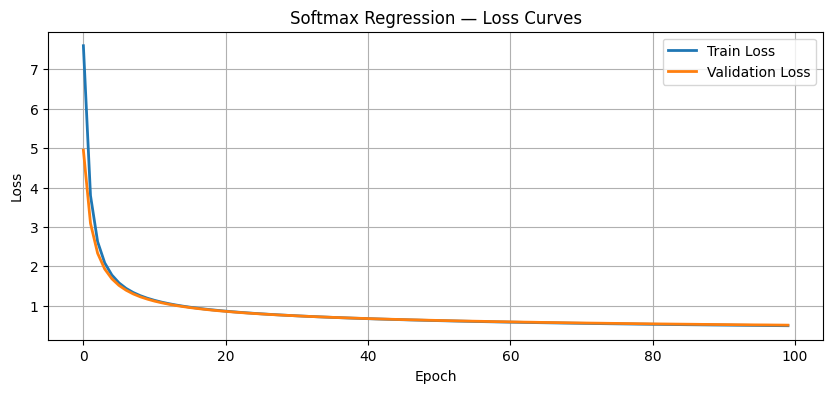

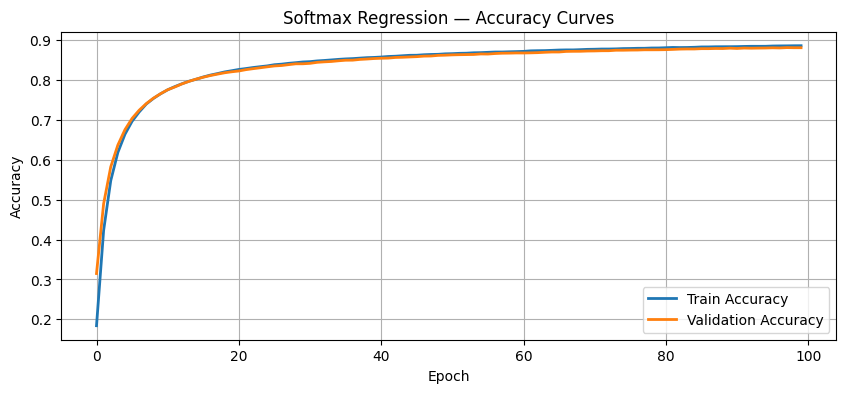

In [15]:
# --- Train the Softmax Regression model ---
result_SM = train_softmax_regression(
    train_loader_SM, 
    val_loader_SM, 
    input_dim=784, 
    num_classes=10, 
    learning_rate=0.01
)

# --- Extract results ---
W = result_SM["W"]
b = result_SM["b"]
train_losses = result_SM["train_losses"]
val_losses = result_SM["val_losses"]
train_accs = result_SM["train_accs"]
val_accs = result_SM["val_accs"]

# --- Plot Loss Curves ---
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Softmax Regression — Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Accuracy Curves ---
plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Train Accuracy', linewidth=2)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Softmax Regression — Accuracy Curves')
plt.legend()
plt.grid(True)
plt.show()


Softmax Regression Manual: Confusion Matrix


Final Test Accuracy: 0.8776


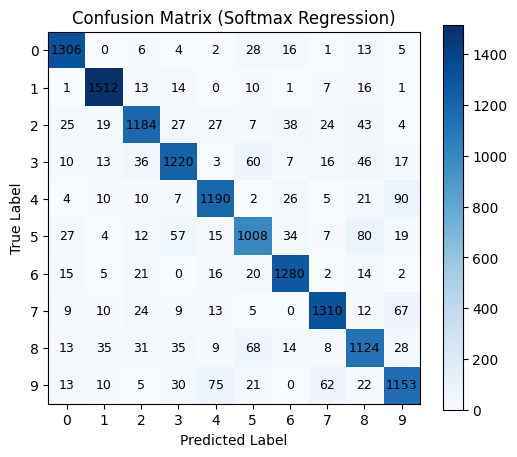


Per-Class Accuracy:
Class 0: 0.9457
Class 1: 0.9600
Class 2: 0.8469
Class 3: 0.8543
Class 4: 0.8718
Class 5: 0.7981
Class 6: 0.9309
Class 7: 0.8979
Class 8: 0.8234
Class 9: 0.8289


In [16]:
# --- Test Evaluation (Manual Confusion Matrix) ---

W.requires_grad = False
b.requires_grad = False

all_preds = []
all_labels = []

with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for X_batch, y_batch in test_loader_SM:
        X_batch = X_batch.view(X_batch.size(0), -1)  # flatten
        y_batch = y_batch.long()  # class labels

        # --- Forward pass ---
        logits = X_batch @ W + b
        y_pred = softmax(logits)  # probabilities
        preds = torch.argmax(y_pred, dim=1)  # predicted class indices

        # --- Append results ---
        all_preds.append(preds)
        all_labels.append(y_batch)

        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

# --- Combine all predictions and labels ---
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# --- Compute overall accuracy ---
test_acc = total_correct / total_samples
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

# --- Manual Confusion Matrix ---
num_classes = b.shape[0] if b.ndim > 0 else 10  # infer number of classes
cm = torch.zeros((num_classes, num_classes), dtype=torch.int32)

for t, p in zip(all_labels, all_preds):
    cm[int(t), int(p)] += 1

# --- Visualization ---
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Softmax Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f"{cm[i,j].item()}", ha='center', va='center', color='black', fontsize=9)

plt.colorbar()
plt.show()

# --- Optional: Per-Class Accuracy ---
per_class_acc = cm.diag().float() / cm.sum(1).float()
print("\nPer-Class Accuracy:")
for i, acc in enumerate(per_class_acc):
    print(f"Class {i}: {acc.item():.4f}")


SoftMax Regression (Built-in)

Initial Data:

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
# Simple Softmax Regression model
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim=784, num_classes=10):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)  # raw logits (CrossEntropyLoss applies softmax internally)

model = SoftmaxRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [19]:
#save the model
softmax_model = model

Softmax Regression (Built-in)
 
Training Loop with Early Stopping

In [20]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(max_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader_SM:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # --- Validation ---
    model.eval()
    with torch.no_grad():
        val_loss, correct_val, total_val = 0, 0, 0
        for X_batch, y_batch in val_loader_SM:
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == y_batch).sum().item()
            total_val += y_batch.size(0)
        val_loss /= total_val
        val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Early stopping check
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_epoch = epoch + 1
        best_metrics = (train_loss, train_acc, val_loss, val_acc)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# --- Final Results ---
final_train_loss, final_train_acc, final_val_loss, final_val_acc = best_metrics
print(f"\nFinal Converged Epoch: {best_epoch}")
print(f"Train Loss: {final_train_loss:.4f} | Train Acc: {final_train_acc:.4f}")
print(f"Val Loss:   {final_val_loss:.4f} | Val Acc:   {final_val_acc:.4f}")



Final Converged Epoch: 99
Train Loss: 0.2725 | Train Acc: 0.9241
Val Loss:   0.2870 | Val Acc:   0.9216


Softmax Regression (Built-in) : Loss and Accuracy Curves

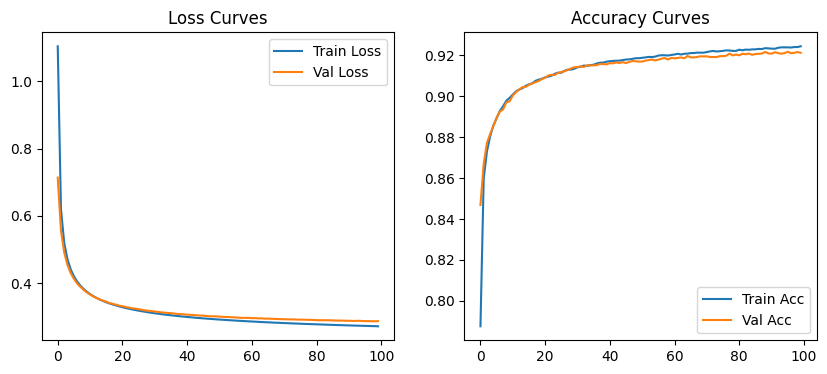

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curves')
plt.legend()
plt.show()


Softmax Regression (Built-in): Confusion Matrix


Final Test Accuracy: 0.9169


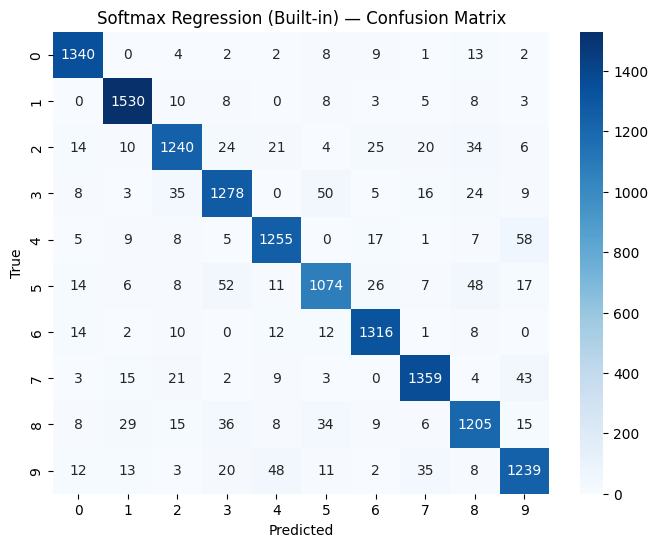


Per-Class Accuracy:
Class 0: 0.9703
Class 1: 0.9714
Class 2: 0.8870
Class 3: 0.8950
Class 4: 0.9194
Class 5: 0.8504
Class 6: 0.9571
Class 7: 0.9315
Class 8: 0.8828
Class 9: 0.8907


In [22]:
# --- Test Evaluation ---
model.eval()
with torch.no_grad():
    X_test_tensor, y_test_tensor = [], []
    for X_batch, y_batch in test_loader_SM:
        X_test_tensor.append(X_batch)
        y_test_tensor.append(y_batch)
    X_test_tensor = torch.cat(X_test_tensor, dim=0)
    y_test_tensor = torch.cat(y_test_tensor, dim=0)

    logits = model(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1)
    test_acc = (y_pred == y_test_tensor).float().mean().item()

print(f"\nFinal Test Accuracy: {test_acc:.4f}")

# --- Confusion Matrix ---
num_classes = 10
conf_mat = torch.zeros(num_classes, num_classes, dtype=torch.int32)
for true, pred in zip(y_test_tensor, y_pred):
    conf_mat[true.long(), pred.long()] += 1

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Softmax Regression (Built-in) — Confusion Matrix')
plt.show()

# --- Per-Class Accuracy ---
per_class_acc = conf_mat.diag() / conf_mat.sum(1)
print("\nPer-Class Accuracy:")
for i, acc in enumerate(per_class_acc):
    print(f"Class {i}: {acc.item():.4f}")


-------------------------------------------------------------

## Part B & D data preparation

In [23]:
import torch
import random
# from torch import random
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from sklearn.model_selection import train_test_split
import numpy as np

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# 1. Load all 70,000 images (Train + Test)
print("Loading and splitting all 70,000 MNIST images...")
X_train_full = datasets.MNIST(root='./data', train=True, download=True).data
y_train_full = datasets.MNIST(root='./data', train=True, download=True).targets
X_test_full = datasets.MNIST(root='./data', train=False, download=True).data
y_test_full = datasets.MNIST(root='./data', train=False, download=True).targets

# 2. Combine and Normalize to [0, 1]
X_all = torch.cat([X_train_full, X_test_full], dim=0).float() / 255.0
y_all = torch.cat([y_train_full, y_test_full], dim=0).long()

# 3. Create the 60/20/20 Stratified Split (on all 10 classes)
# First split: 80% train+val, 20% test
X_temp, X_test_10, y_temp, y_test_10 = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
# Second split: 75% train, 25% val from the 80%
X_train_10, X_val_10, y_train_10, y_val_10 = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"\nTotal 10-class samples: {len(X_all)}")
print(f"Train (10-class): {len(X_train_10)} (~60%)")
print(f"Val (10-class):   {len(X_val_10)} (~20%)")
print(f"Test (10-class):  {len(X_test_10)} (~20%)")

# 4. Create DataLoaders for EACH part
BATCH_SIZE = 64

#Loaders for Part B (FNN)
# Data needs to be FLATTENED (784 features)
train_loader_fnn = DataLoader(TensorDataset(X_train_10.view(-1, 28*28), y_train_10), batch_size=BATCH_SIZE, shuffle=True)
val_loader_fnn = DataLoader(TensorDataset(X_val_10.view(-1, 28*28), y_val_10), batch_size=BATCH_SIZE)
test_loader_fnn = DataLoader(TensorDataset(X_test_10.view(-1, 28*28), y_test_10), batch_size=BATCH_SIZE)

# Loaders for Part D (CNN)
# Data needs the channel dimension: [N, 1, 28, 28]
# We also apply standard MNIST normalization
mean = 0.1307
std = 0.3081
X_train_cnn = (X_train_10.unsqueeze(1) - mean) / std
X_val_cnn = (X_val_10.unsqueeze(1) - mean) / std
X_test_cnn = (X_test_10.unsqueeze(1) - mean) / std

train_loader_original = DataLoader(TensorDataset(X_train_cnn, y_train_10), batch_size=BATCH_SIZE, shuffle=True)
val_loader_original = DataLoader(TensorDataset(X_val_cnn, y_val_10), batch_size=BATCH_SIZE)
test_loader_original = DataLoader(TensorDataset(X_test_cnn, y_test_10), batch_size=BATCH_SIZE)


Loading and splitting all 70,000 MNIST images...

Total 10-class samples: 70000
Train (10-class): 42000 (~60%)
Val (10-class):   14000 (~20%)
Test (10-class):  14000 (~20%)


## Custom Neural Network Architecture
    - flexible feedforward neural network with customizable architecture.
    - input -> hidden1 -> hidden2 -> output
    - ReLU activation for hidden layers
    - Proper weight initialization (Xavier/He)

In [24]:
class NeuralNetwork(nn.Module):
    
    #set up the layers and other settings
    def __init__(self, input_size: int, hidden_sizes: List[int], output_size: int, 
                 activation: str = 'relu', init_method: str = 'xavier', dropout_rate:float=0.2):

        # Initialize the neural network.
        #input_size: Number of input features (784 for MNIST)
        #hidden_sizes: List of hidden layer sizes [Hidden1, Hidden2, ...]
        #output_size: Number of output classes (0->9)
        #activation: Activation function ('relu' or 'tanh')
        #init_method: Weight initialization ('xavier' or 'he')
        # dropout_rate: probability of turning off neurons (0.0 = no dropout)
    
        super(NeuralNetwork, self).__init__()
        
        #stores actions
        self.activation = activation
        self.init_method = init_method
        self.dropout_rate = dropout_rate

        #craete list that will hold layers
        self.layers = nn.ModuleList()#pytorch can find parameters inside it automatically
        self.dropouts = nn.ModuleList()  #store one dropout layer per hidden layer

        # create all hidden layers
        layer_sizes = [input_size] + hidden_sizes
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))#connected layers 
            self.dropouts.append(nn.Dropout(p=dropout_rate))  # Add dropout after each layer
        # connects them like this:
        # Layer 1: 784 → 128
        # Layer 2: 128 → 64

        # connect Output layer to hidden layers
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        # 64 → (0->9)
        
        # Initialize weights
        self._initialize_weights()

    #This part goes through all the hidden layers and sets the starting weights
    def _initialize_weights(self):
        # proper weight initialization 
        for layer in self.layers:
            # Keeps signal size steady between layers (xavier)
            if self.init_method == 'xavier':#prevent activations from shrinking or blowing up as they pass through layers.
                nn.init.xavier_uniform_(layer.weight)#good for tanh activation
            elif self.init_method == 'he':#make sure the non-zero activations stay balanced and don’t vanish.
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')#good for relu
            nn.init.zeros_(layer.bias)
        
        # Initialize output layer
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    #define how the data flows through the network
    def forward(self, x: torch.Tensor) -> torch.Tensor:
    
        # Forward pass through the network.
        # Input -> Hidden1(ReLU) -> Hidden2(ReLU) -> Output

        # Pass through hidden layers with ReLU activation to make it non-linear
        #Without activation functions, the network would just act like a single linear layer!
        for i,layer in enumerate(self.layers):
            x = layer(x)
            if self.activation == 'relu':
                x = F.relu(x)
            elif self.activation == 'tanh':
                x = torch.tanh(x)
            x = self.dropouts[i](x)#only active during training

        # Output layer (no activation - raw logits)
        x = self.output_layer(x) 
        return x


## Custom training structure:
    - Complete training loop from scratch
    - Support for batch processing
    - Proper gradient computation and backpropagation
    - Train/validation split handling
    - Progress tracking and logging
    - SGD optimizer with learning rate 0.01
    - Cross-entropy loss
    - Batch size 64

In [25]:
class NeuralNetworkTrainer:
     
    def __init__(self, model: nn.Module, learning_rate: float = 0.01, device: str = None, patience: int = 5, min_delta: float = 0.001):

        #stores functions
        self.model = model
        self.learning_rate = learning_rate
        self.patience = patience        # how many epochs to wait without improvement
        self.min_delta = min_delta      # minimum change in val loss to be considered an improvement

        #CPU -> computer's processor (works everywhere, but slower).
        #GPU (CUDA) -> graphics card (much faster for deep learning).
        #The device tells PyTorch where to do all the math.
        #computer has more than one place that can do calculations (CPU and GPU) and PyTorch can use either.
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        self.model.to(self.device)
        
        #optimizer (SGD)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        
        #Loss function->Cross-entropy
        self.criterion = nn.CrossEntropyLoss()
        
        #Training history for ploting
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'epoch_times': []
        }
        # Early stopping state
        self.best_val_loss = float('inf')
        self.best_model_state = None
        self.epochs_no_improve = 0
        self.early_stop = False
    
    # Teaches the model using training data
    def _train_epoch(self, train_loader: DataLoader) -> Tuple[float, float]:
        
        # train for one epoch with batch processing and gradient computation.
        # train_loader: DataLoader for training data

        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        # Batch processing
        #batch_x for model and predict outputs
        #batch_y compared with predictions
        for batch_X, batch_y in train_loader:
            #Model and data must be on the same device for computations or device mismatch error
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)
            
            # Zero gradients
            # avoid mixing gradients from multiple batches
            self.optimizer.zero_grad()
            
            # Forward pass to calculate model predictions
            outputs = self.model(batch_X)
            # cross entropy loss
            loss = self.criterion(outputs, batch_y)
            
            # Backward pass - gradient computation
            loss.backward()
            
            # Update weights - backpropagation
            self.optimizer.step()
            
            # Track metrics
            total_loss += loss.item() * batch_X.size(0) #calculate total loss for all samples in batch_x
            _, predicted = torch.max(outputs.data, 1) #get max value in each raw model predictions for this batch (logits)
            total += batch_y.size(0) #number of true labels 
            correct += (predicted == batch_y).sum().item()#compares predicted labels to true labels if true add it to correct
        
        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        
        return avg_loss, accuracy
    
    # Tests the model on unseen data
    def _validate_epoch(self, val_loader: DataLoader) -> Tuple[float, float]:
   
        # val_loader: DataLoader for validation data

        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                
                total_loss += loss.item() * batch_X.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        
        return avg_loss, accuracy
    
    # Repeats both (train_epoch & validate_epoch) for several epochs until the model learns well
    def train(self, train_loader: DataLoader, val_loader: DataLoader, 
              epochs: int = 50, display_info: bool = True) -> Dict:
            
        if display_info:
            print("\n" + "=" * 70)
            print("TRAINING CONFIGURATION")
            print("=" * 70)
            print(f"Device: {self.device}")
            print(f"Optimizer: SGD")
            print(f"Learning rate: {self.learning_rate}")
            print(f"Loss function: Cross-entropy")
            print(f"Batch size: {train_loader_fnn.batch_size}")
            print(f"Epochs:{epochs}")
            print("=" * 70)
        
        # Training loop
        for epoch in range(epochs):
            start_time = time.time()
            
            # Train one model to updates its weights
            train_loss, train_acc = self._train_epoch(train_loader_fnn)
            
            # Validate to check progress
            val_loss, val_acc = self._validate_epoch(val_loader_fnn)
            
            # Record time
            epoch_time = time.time() - start_time
            
            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['epoch_times'].append(epoch_time)
            
            #Early stopping check
            if val_loss + self.min_delta < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_model_state = self.model.state_dict()  # save best model
                self.epochs_no_improve = 0
            else:
                self.epochs_no_improve += 1
                if self.epochs_no_improve >= self.patience:
                    print(f"\nEarly stopping triggered after {epoch+1} epochs.")
                    self.early_stop = True
                    break

            # Progress logging (every 5 models print to watch the model improve) 
            if display_info and (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch+1:3d}/{epochs}] | "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:6.2f}% | "
                      f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:6.2f}% | "
                      f"Time: {epoch_time:.2f}s")
                
        #Load the best model if early stopped
        if self.early_stop and self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)

        if display_info:
            print("=" * 70)
            print("TRAINING COMPLETED!")
            print(f"Final Train Accuracy: {self.history['train_acc'][-1]:.2f}%")
            print(f"Final Val Accuracy: {self.history['val_acc'][-1]:.2f}%")
            print("=" * 70)
        
        return self.history
    
    # Uses the trained model to make predictions on new data
    def predict(self, X: np.ndarray) -> np.ndarray:
        
        self.model.eval()
        X_tensor = torch.FloatTensor(X).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1) #torch.max(..., 1) finds the index of the largest value in each row (the predicted class).
        
        return predicted.cpu().numpy()
    
    # measures final performance after training
    def evaluate(self, test_loader: DataLoader) -> Tuple[float, float]:

        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad(): #Tells PyTorch not to compute gradients (not training the model)
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                
                total_loss += loss.item() * batch_X.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        
        return avg_loss, accuracy


In [26]:
class PerformanceVisualizer:

    def __init__(self, history: dict):
      
        self.history = history
        self.epochs = np.arange(1, len(history['train_loss']) + 1)

    # Basic loss and accuracy plots 

    def plot_loss_curves(self, save_path: str = "loss_curves.png"):
        """Plot training and validation loss over epochs"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.epochs, self.history['train_loss'], 
                marker='o', markersize=4, label='Training Loss', linewidth=2)
        plt.plot(self.epochs, self.history['val_loss'], 
                marker='s', markersize=4, label='Validation Loss', linewidth=2)
        plt.xlabel("Epochs", fontsize=12, fontweight='bold')
        plt.ylabel("Loss", fontsize=12, fontweight='bold')
        plt.title("Training and Validation Loss Over Epochs", fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved loss curve to {save_path}")
        plt.show()

    def plot_accuracy_curves(self, save_path: str = "accuracy_curves.png"):
        """Plot training and validation accuracy over epochs"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.epochs, self.history['train_acc'], 
                marker='o', markersize=4, label='Training Accuracy', linewidth=2)
        plt.plot(self.epochs, self.history['val_acc'], 
                marker='s', markersize=4, label='Validation Accuracy', linewidth=2)
        plt.xlabel("Epochs", fontsize=12, fontweight='bold')
        plt.ylabel("Accuracy (%)", fontsize=12, fontweight='bold')
        plt.title("Training and Validation Accuracy Over Epochs", fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved accuracy curve to {save_path}")
        plt.show()

    # Learning curves with error bars 

    def plot_learning_curves(self, window: int = 5, save_path: str = "learning_curves_with_error.png"):
        train_loss = np.array(self.history['train_loss'])
        val_loss = np.array(self.history['val_loss'])
        
        # Compute moving standard deviation (proper error bars)
        def compute_moving_std(data, window_size):
            stds = []
            for i in range(len(data)):
                start = max(0, i - window_size + 1)
                window_data = data[start:i+1]
                stds.append(np.std(window_data) if len(window_data) > 1 else 0)
            return np.array(stds)
        
        train_err = compute_moving_std(train_loss, window)
        val_err = compute_moving_std(val_loss, window)
        
        plt.figure(figsize=(12, 6))
        
        # Plot with error bars
        plt.errorbar(self.epochs, train_loss, yerr=train_err, 
                    fmt='-o', markersize=4, capsize=3, capthick=1,
                    label=f'Train Loss ± std (window={window})', 
                    linewidth=2, alpha=0.8)
        plt.errorbar(self.epochs, val_loss, yerr=val_err, 
                    fmt='-s', markersize=4, capsize=3, capthick=1,
                    label=f'Val Loss ± std (window={window})', 
                    linewidth=2, alpha=0.8)
        
        plt.xlabel("Epochs", fontsize=12, fontweight='bold')
        plt.ylabel("Loss", fontsize=12, fontweight='bold')
        plt.title("Learning Curves with Error Bars", fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved learning curve with error bars to {save_path}")
        plt.show()

    def plot_learning_curves_shaded(self, window: int = 5, 
                                    save_path: str = "learning_curves_shaded.png"):
        
        train_loss = np.array(self.history['train_loss'])
        val_loss = np.array(self.history['val_loss'])
        
        # Compute moving statistics
        def compute_moving_stats(data, window_size):
            means = []
            stds = []
            for i in range(len(data)):
                start = max(0, i - window_size + 1)
                window_data = data[start:i+1]
                means.append(np.mean(window_data))
                stds.append(np.std(window_data) if len(window_data) > 1 else 0)
            return np.array(means), np.array(stds)
        
        train_mean, train_std = compute_moving_stats(train_loss, window)
        val_mean, val_std = compute_moving_stats(val_loss, window)
        
        plt.figure(figsize=(12, 6))
        
        # Plot training loss with shaded error
        plt.plot(self.epochs, train_mean, 'b-', linewidth=2, label='Training Loss')
        plt.fill_between(self.epochs, 
                        train_mean - train_std, 
                        train_mean + train_std, 
                        alpha=0.2, color='blue')
        
        # Plot validation loss with shaded error
        plt.plot(self.epochs, val_mean, 'r-', linewidth=2, label='Validation Loss')
        plt.fill_between(self.epochs, 
                        val_mean - val_std, 
                        val_mean + val_std, 
                        alpha=0.2, color='red')
        
        plt.xlabel("Epochs", fontsize=12, fontweight='bold')
        plt.ylabel("Loss", fontsize=12, fontweight='bold')
        plt.title(f"Learning Curves with Shaded Error Regions (window={window})", 
                 fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved shaded learning curves to {save_path}")
        plt.show()

    # Convergence analysis 

    def plot_convergence_analysis(self, save_path: str = "convergence_analysis.png"):
       
        val_loss = np.array(self.history['val_loss'])
        train_loss = np.array(self.history['train_loss'])
        val_acc = np.array(self.history['val_acc'])
        train_acc = np.array(self.history['train_acc'])
        
        best_epoch = np.argmin(val_loss) + 1
        best_val_loss = val_loss[best_epoch - 1]
        best_val_acc = val_acc[best_epoch - 1]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Loss convergence
        axes[0, 0].plot(self.epochs, train_loss, 'b-', label="Train Loss", linewidth=2)
        axes[0, 0].plot(self.epochs, val_loss, 'r-', label="Val Loss", linewidth=2)
        axes[0, 0].axvline(best_epoch, color='green', linestyle='--', 
                          label=f"Best Epoch = {best_epoch}", linewidth=2)
        axes[0, 0].scatter(best_epoch, best_val_loss, color='red', s=100, zorder=5)
        axes[0, 0].set_xlabel("Epochs", fontsize=11, fontweight='bold')
        axes[0, 0].set_ylabel("Loss", fontsize=11, fontweight='bold')
        axes[0, 0].set_title("Loss Convergence", fontsize=12, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Generalization gap
        gap = train_acc - val_acc
        axes[0, 1].plot(self.epochs, gap, 'g-', linewidth=2)
        axes[0, 1].axhline(0, color='black', linestyle='--', alpha=0.5)
        axes[0, 1].fill_between(self.epochs, 0, gap, alpha=0.3, color='green')
        axes[0, 1].set_xlabel("Epochs", fontsize=11, fontweight='bold')
        axes[0, 1].set_ylabel("Accuracy Gap (%)", fontsize=11, fontweight='bold')
        axes[0, 1].set_title("Generalization Gap (Train - Val Acc)", fontsize=12, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Loss improvement rate
        train_loss_diff = np.diff(train_loss)
        val_loss_diff = np.diff(val_loss)
        axes[1, 0].plot(self.epochs[1:], train_loss_diff, 'b-', 
                       label='Train Loss Change', linewidth=2)
        axes[1, 0].plot(self.epochs[1:], val_loss_diff, 'r-', 
                       label='Val Loss Change', linewidth=2)
        axes[1, 0].axhline(0, color='black', linestyle='--', alpha=0.5)
        axes[1, 0].set_xlabel("Epochs", fontsize=11, fontweight='bold')
        axes[1, 0].set_ylabel("Loss Change", fontsize=11, fontweight='bold')
        axes[1, 0].set_title("Loss Improvement Rate", fontsize=12, fontweight='bold')
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Accuracy progression
        axes[1, 1].plot(self.epochs, train_acc, 'b-', label='Train Acc', linewidth=2)
        axes[1, 1].plot(self.epochs, val_acc, 'r-', label='Val Acc', linewidth=2)
        axes[1, 1].axvline(best_epoch, color='green', linestyle='--', 
                          label=f"Best Epoch = {best_epoch}", linewidth=2)
        axes[1, 1].scatter(best_epoch, best_val_acc, color='red', s=100, zorder=5)
        axes[1, 1].set_xlabel("Epochs", fontsize=11, fontweight='bold')
        axes[1, 1].set_ylabel("Accuracy (%)", fontsize=11, fontweight='bold')
        axes[1, 1].set_title("Accuracy Progression", fontsize=12, fontweight='bold')
        axes[1, 1].legend(fontsize=10)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved convergence analysis to {save_path}")
        plt.show()


## Build and train the Neural Network

In [27]:
# Model configuration
input_size = 28 * 28   # flattened MNIST image size
hidden_layers = [128, 64]  # flexible architecture
output_size = 10         # binary classification (digits 0 and 1)

# Initialize model
model = NeuralNetwork(
    input_size=input_size,
    hidden_sizes=hidden_layers,
    output_size=output_size,
    activation='relu',      # ReLU for hidden layers
    init_method='xavier'    # Xavier initialization
)

# Create trainer (SGD optimizer, CrossEntropy loss)
trainer = NeuralNetworkTrainer(model, learning_rate=0.01)

# Train model (using your pre-made DataLoaders)
history = trainer.train(train_loader_fnn, val_loader_fnn, epochs=50)

#save the best model 
torch.save(model.state_dict(), "best_nn_model.pth")


TRAINING CONFIGURATION
Device: cpu
Optimizer: SGD
Learning rate: 0.01
Loss function: Cross-entropy
Batch size: 64
Epochs:50
Epoch [  5/50] | Train Loss: 0.3896 | Train Acc:  88.68% | Val Loss: 0.2781 | Val Acc:  92.04% | Time: 1.56s
Epoch [ 10/50] | Train Loss: 0.2791 | Train Acc:  91.76% | Val Loss: 0.2073 | Val Acc:  93.96% | Time: 1.75s
Epoch [ 15/50] | Train Loss: 0.2291 | Train Acc:  93.22% | Val Loss: 0.1717 | Val Acc:  94.90% | Time: 1.89s
Epoch [ 20/50] | Train Loss: 0.1968 | Train Acc:  94.22% | Val Loss: 0.1503 | Val Acc:  95.51% | Time: 1.67s
Epoch [ 25/50] | Train Loss: 0.1774 | Train Acc:  94.81% | Val Loss: 0.1376 | Val Acc:  95.90% | Time: 1.67s
Epoch [ 30/50] | Train Loss: 0.1541 | Train Acc:  95.52% | Val Loss: 0.1271 | Val Acc:  96.13% | Time: 1.76s
Epoch [ 35/50] | Train Loss: 0.1426 | Train Acc:  95.76% | Val Loss: 0.1173 | Val Acc:  96.49% | Time: 1.91s
Epoch [ 40/50] | Train Loss: 0.1319 | Train Acc:  96.06% | Val Loss: 0.1117 | Val Acc:  96.71% | Time: 1.86s
Epo

## Evaluate on the Test Set

In [28]:
test_loss, test_acc = trainer.evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0469 | Test Accuracy: 98.93%


## Visualize Performance 

✓ Saved loss curve to loss_curves.png


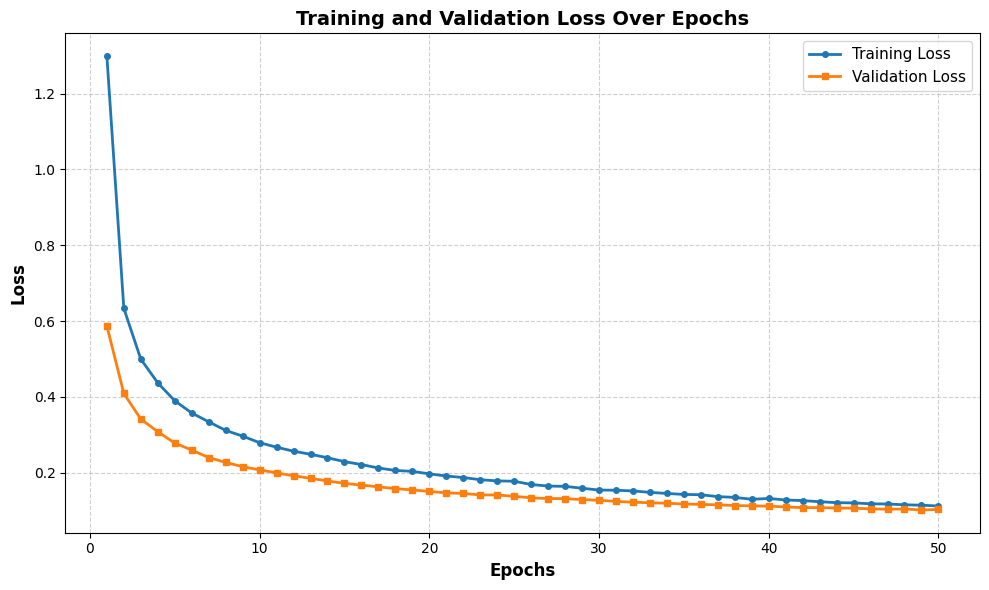

✓ Saved accuracy curve to accuracy_curves.png


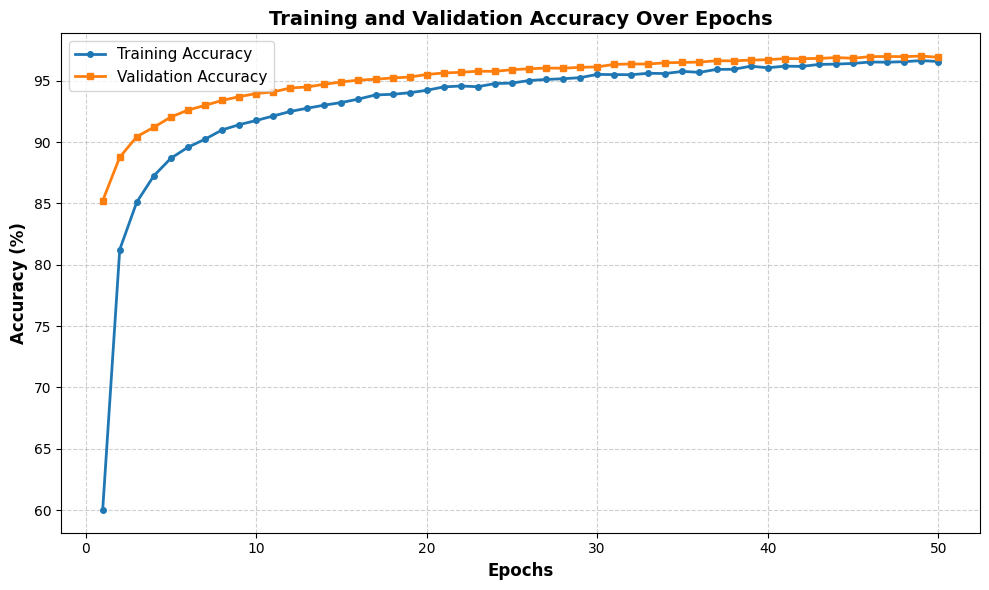

✓ Saved learning curve with error bars to learning_curves_with_error.png


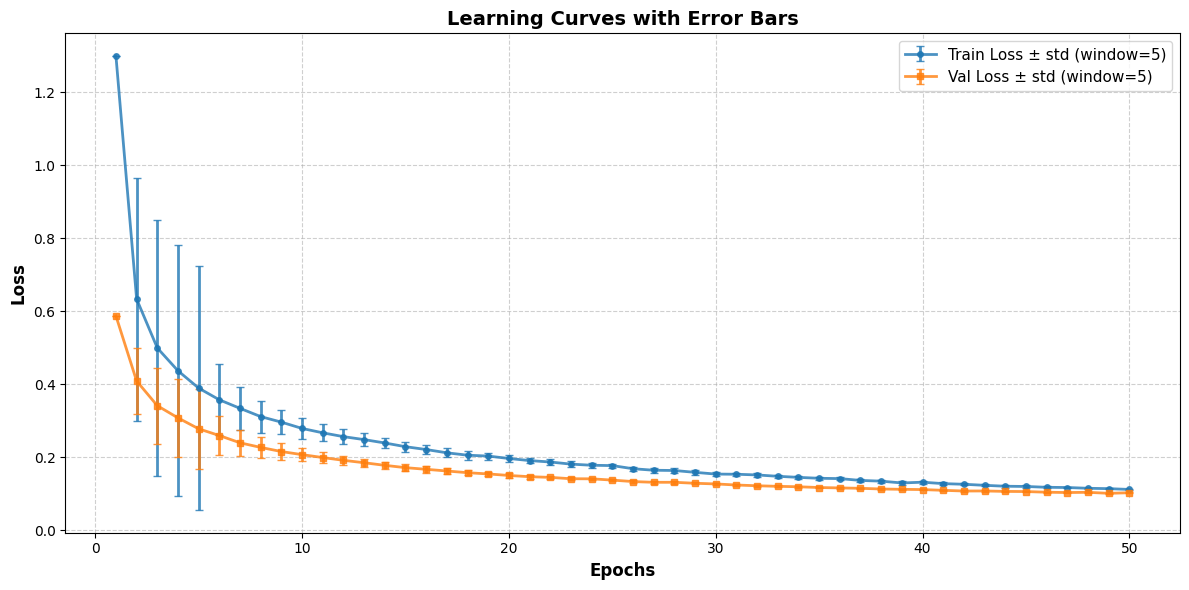

✓ Saved shaded learning curves to learning_curves_shaded.png


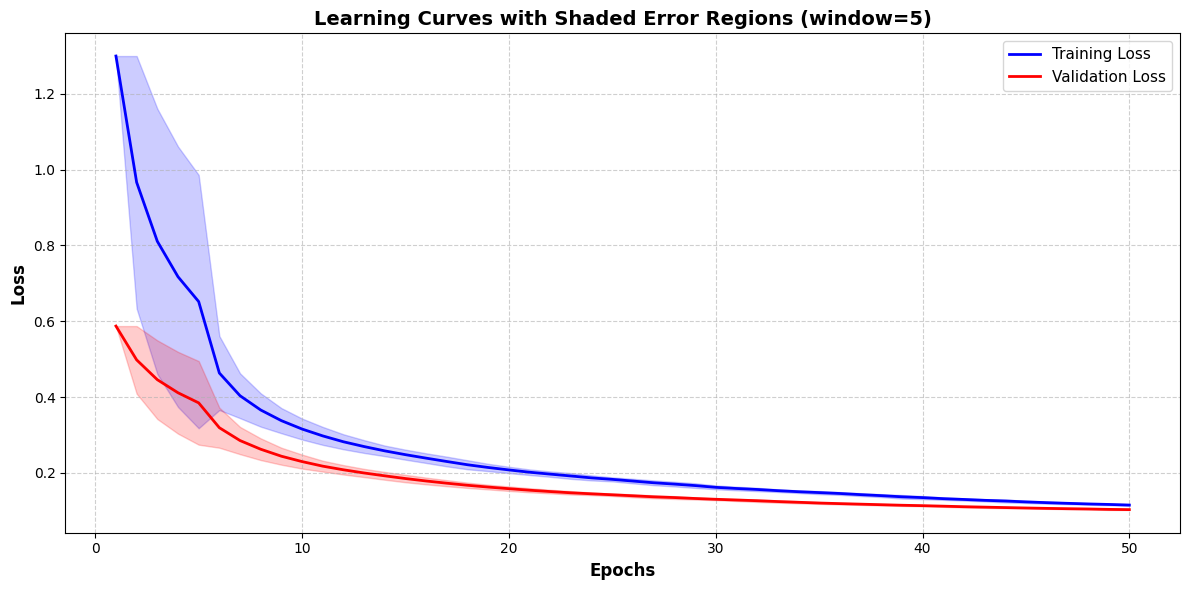

✓ Saved convergence analysis to convergence_analysis.png


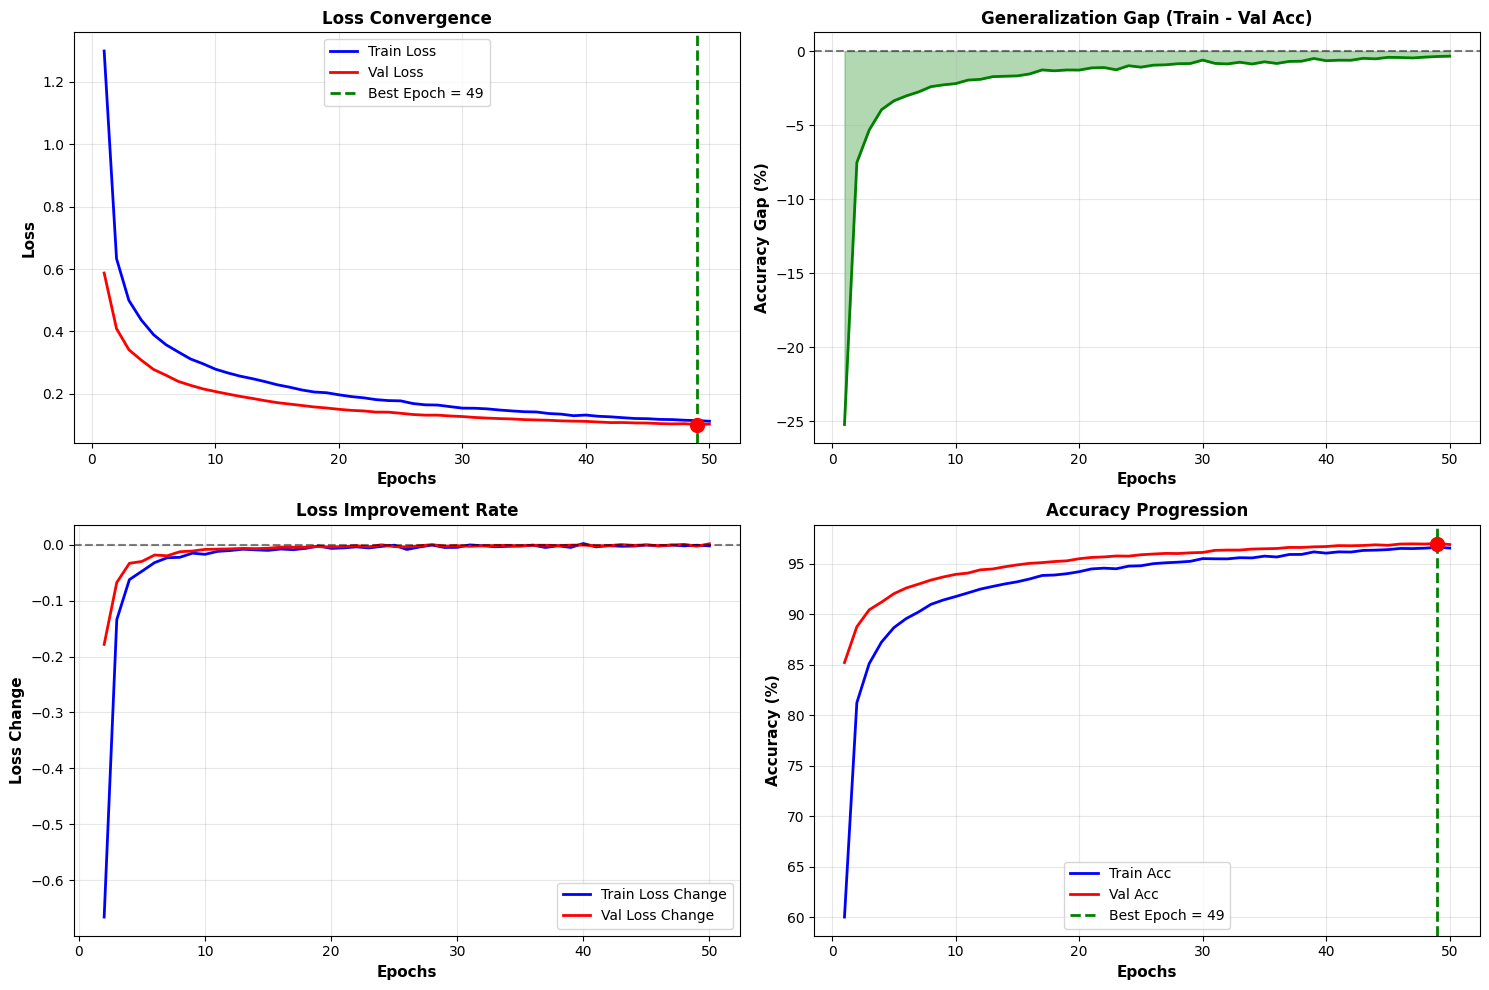

In [29]:
viz = PerformanceVisualizer(trainer.history)
viz.plot_loss_curves()
viz.plot_accuracy_curves()
viz.plot_learning_curves(window=5)
viz.plot_learning_curves_shaded(window=5) 
viz.plot_convergence_analysis()

## Learning rate analysis (Neural)

In [30]:
print("--- C1: Using 60/20/20 data from Part A3 ---")
print(f"Train samples: {len(train_dataset_SM)} | Val samples: {len(val_dataset_SM)} | Test samples: {len(test_dataset_SM)}")
#print("-" * 30)

--- C1: Using 60/20/20 data from Part A3 ---
Train samples: 42000 | Val samples: 14000 | Test samples: 14000


In [31]:
def plot_learning_curves(histories: Dict[str, Dict], title: str):
    plt.figure(figsize=(12, 5))
    
    # Plot Training Loss
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        plt.plot(history['train_loss'], label=f'Train ({name})')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Validation Loss
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history['val_loss'], label=f'Val ({name})')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.suptitle(title)
    plt.show()


baseline_config = {
    'lr': 0.01,
    'batch_size': 64,
    'hidden_sizes': [128],  # 1 hidden layer with 128 neurons
    'activation': 'relu',
    'init_method': 'he',
    'dropout_rate': 0.2,
    'patience': 5,
    'epochs': 50
}

print("Setup complete. Baseline configuration defined.")

Setup complete. Baseline configuration defined.


--- C1.1: Learning Rate Analysis ---
Testing Learning Rate: 0.001
Testing Learning Rate: 0.01
Testing Learning Rate: 0.1

Early stopping triggered after 30 epochs.
Testing Learning Rate: 1.0

Early stopping triggered after 12 epochs.
Learning Rate analysis complete.


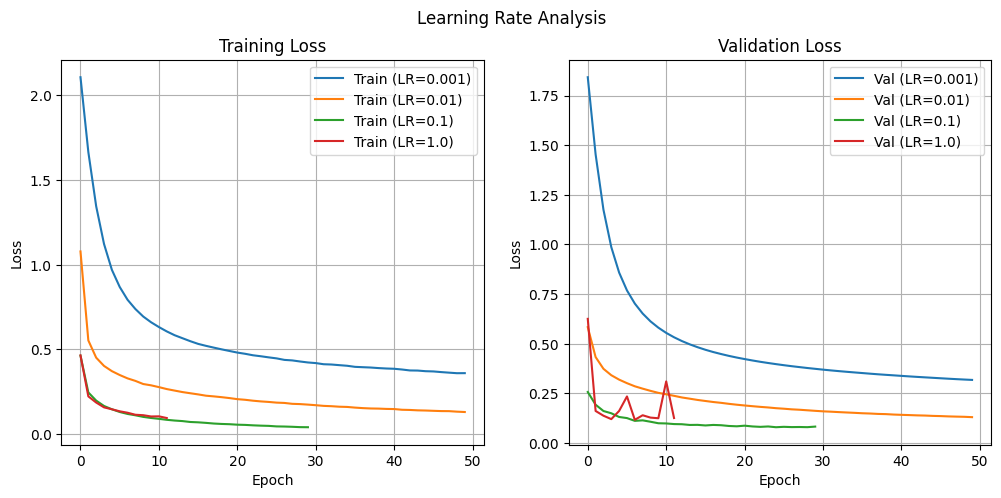


Learning Rate vs. Best Validation Accuracy:
      lr  best_val_acc
2  0.100     97.685714
3  1.000     96.878571
1  0.010     96.250000
0  0.001     91.435714


In [32]:
import pandas as pd
# C1.1 - Learning Rate Analysis
print("--- C1.1: Learning Rate Analysis ---")

learning_rates_to_test = [0.001, 0.01, 0.1, 1.0]
lr_histories = {}
lr_results = []

# Use baseline data loaders (batch_size=64)
train_loader_base = DataLoader(train_dataset_SM, batch_size=baseline_config['batch_size'], shuffle=True)
val_loader_base = DataLoader(val_dataset_SM, batch_size=baseline_config['batch_size'])

for lr in learning_rates_to_test:
    print(f"Testing Learning Rate: {lr}")
    
    # Use baseline architecture
    model = NeuralNetwork(
        input_size=784,
        hidden_sizes=baseline_config['hidden_sizes'],
        output_size=10,
        activation=baseline_config['activation'],
        init_method=baseline_config['init_method'],
        dropout_rate=baseline_config['dropout_rate']
    )
    
    trainer = NeuralNetworkTrainer(
        model=model,
        learning_rate=lr, # Vary this parameter
        patience=baseline_config['patience']
    )
    
    history = trainer.train(
        train_loader=train_loader_base,
        val_loader=val_loader_base,
        epochs=baseline_config['epochs'],
        display_info=False
    )
    
    lr_histories[f"LR={lr}"] = history
    lr_results.append({'lr': lr, 'best_val_acc': max(history['val_acc'])})

print("Learning Rate analysis complete.")

# Plot the learning curves
plot_learning_curves(lr_histories, "Learning Rate Analysis")

# Show final accuracy comparison
lr_df = pd.DataFrame(lr_results).sort_values(by='best_val_acc', ascending=False)
print("\nLearning Rate vs. Best Validation Accuracy:")
print(lr_df)

## Convergence Speed
- lr=1.0 (Too High): The loss exploded
- lr=0.1 (Fast): This learning rate shows the fastest convergence,The validation loss drops quickly and reaches min in few epochs
- lr=0.01 (Moderate): This rate is stable and converges steadily but takes more epochs than 0.1
- lr=0.001 (Too Low): This rate learns very slowly. The loss decreases, but at a very shallow slope.

## Stability & Performance
- lr=0.1 achieves the best final validation accuracy, finding a good minimum quickly.
- lr=0.01 is also very stable
- lr=1.0 & 0.001 unstable

0.1 is the best choice

## batch size analysis (Neural)


--- C1.2: Batch Size Analysis ---
Testing Batch Size: 16
Testing Batch Size: 32
Testing Batch Size: 64
Testing Batch Size: 128
Batch Size analysis complete.


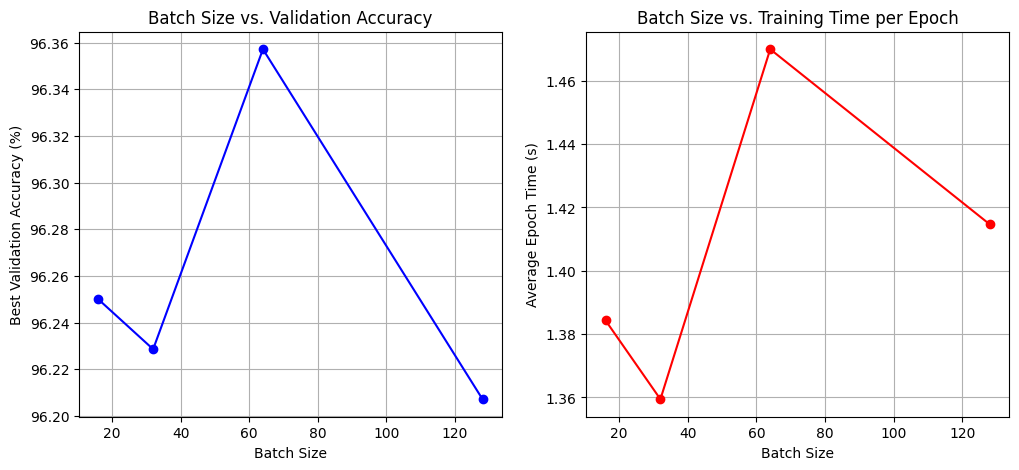

   batch_size  best_val_acc  avg_epoch_time
0          16     96.250000        1.384330
1          32     96.228571        1.359433
2          64     96.357143        1.469979
3         128     96.207143        1.414647


In [33]:
# C1.2 - Batch Size Analysis
print("\n--- C1.2: Batch Size Analysis ---")

batch_sizes_to_test = [16, 32, 64, 128]
bs_results = []
bs_histories = {} # Store histories for time analysis

for b_size in batch_sizes_to_test:
    print(f"Testing Batch Size: {b_size}")
    
    # Create new DataLoaders with the current batch size
    train_loader_bs = DataLoader(train_dataset_SM, batch_size=b_size, shuffle=True)
    val_loader_bs = DataLoader(val_dataset_SM, batch_size=b_size)
    
    # Use baseline model and LR
    model = NeuralNetwork(
        input_size=784,
        hidden_sizes=baseline_config['hidden_sizes'],
        output_size=10,
        activation=baseline_config['activation'],
        init_method=baseline_config['init_method'],
        dropout_rate=baseline_config['dropout_rate']
    )
    
    trainer = NeuralNetworkTrainer(
        model=model,
        learning_rate=baseline_config['lr'], # Use baseline LR
        patience=baseline_config['patience']
    )

    history = trainer.train(
        train_loader=train_loader_bs,
        val_loader=val_loader_bs,
        epochs=baseline_config['epochs'],
        display_info=False
    )
    
    bs_histories[f"BS={b_size}"] = history
    bs_results.append({
        'batch_size': b_size, 
        'best_val_acc': max(history['val_acc']),
        'avg_epoch_time': np.mean(history['epoch_times'])
    })

print("Batch Size analysis complete.")

# Plot the results
bs_df = pd.DataFrame(bs_results).sort_values(by='batch_size')
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(bs_df['batch_size'], bs_df['best_val_acc'], 'bo-')
plt.title('Batch Size vs. Validation Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Best Validation Accuracy (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(bs_df['batch_size'], bs_df['avg_epoch_time'], 'ro-')
plt.title('Batch Size vs. Training Time per Epoch')
plt.xlabel('Batch Size')
plt.ylabel('Average Epoch Time (s)')
plt.grid(True)

plt.show()
print(bs_df)

## Training Efficiency (Time):
- batch size = 32 is the most effecient per epoch


## final performance
- Smaller batch sizes 16 lead to better final accuracy. This is because they introduce more "noise" into the gradient updates, which can help the model escape (bad solutions) and find a better, more generalizable solution.

## gradient noise
- batch_size=16 (High Noise): The gradients are very noisy (they jump around a lot) because they are based on only 16 samples. This makes the training loss curve look erratic but can help generalization.
- batch_size=128 (Low Noise): The gradients are much more stable and the loss curve is smoother, but this can sometimes cause the model to get stuck in a "sharper" minimum, which doesn't generalize as well to new data.
- batch size of 32 or 64 is the average between them 

## Architecture analysis: Neurons per layer


--- C1.3: Neuron Analysis (Single Layer) ---
Testing Hidden Size: [64]
Testing Hidden Size: [128]
Testing Hidden Size: [256]
Testing Hidden Size: [512]
Neuron analysis complete.


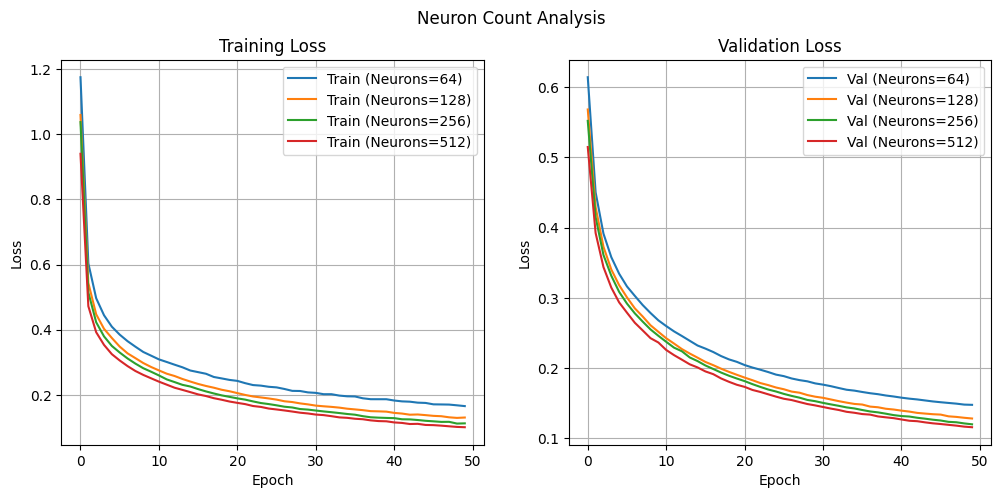

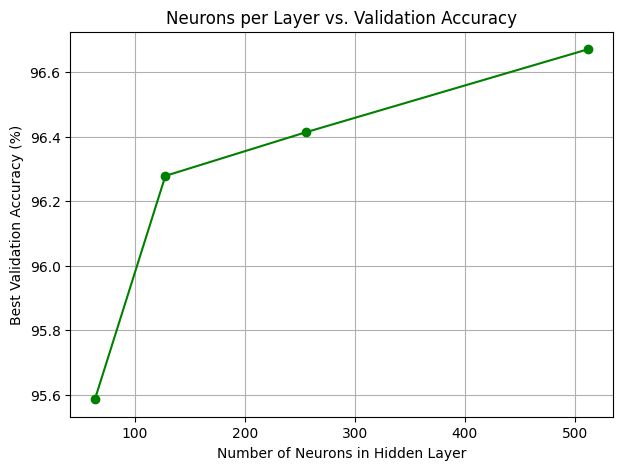

   neurons  best_val_acc
0       64     95.585714
1      128     96.278571
2      256     96.414286
3      512     96.671429


In [40]:
# C1.3 - Architecture Analysis (Neurons)
print("\n--- C1.3: Neuron Analysis (Single Layer) ---")

neuron_counts_to_test = [[64], [128], [256], [512]]
neuron_results = []
neuron_histories = {}

# Use baseline data loaders (batch_size=64)
train_loader_base = DataLoader(train_dataset_SM, batch_size=baseline_config['batch_size'], shuffle=True)
val_loader_base = DataLoader(val_dataset_SM, batch_size=baseline_config['batch_size'])

for h_size in neuron_counts_to_test:
    print(f"Testing Hidden Size: {h_size}")
    
    # Use baseline LR, but vary the hidden_sizes
    model = NeuralNetwork(
        input_size=784,
        hidden_sizes=h_size, # Vary this parameter
        output_size=10,
        activation=baseline_config['activation'],
        init_method=baseline_config['init_method'],
        dropout_rate=baseline_config['dropout_rate']
    )
    
    trainer = NeuralNetworkTrainer(
        model=model,
        learning_rate=baseline_config['lr'], # Use baseline LR
        patience=baseline_config['patience']
    )

    history = trainer.train(
        train_loader=train_loader_base,
        val_loader=val_loader_base,
        epochs=baseline_config['epochs'],
        display_info=False
    )
    
    neuron_histories[f"Neurons={h_size[0]}"] = history
    neuron_results.append({
        'neurons': h_size[0], 
        'best_val_acc': max(history['val_acc'])
    })

print("Neuron analysis complete.")

# Plot the learning curves
plot_learning_curves(neuron_histories, "Neuron Count Analysis")

# Plot final accuracy
neuron_df = pd.DataFrame(neuron_results).sort_values(by='neurons')
plt.figure(figsize=(7, 5))
plt.plot(neuron_df['neurons'], neuron_df['best_val_acc'], 'go-')
plt.title('Neurons per Layer vs. Validation Accuracy')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Best Validation Accuracy (%)')
plt.grid(True)
plt.show()
print(neuron_df)

best model accuracy is 512 neurons, worst is 64 
because a model with more parameters (higher capacity) can "fit" or memorize the training data more effectively.

## Architecture Analysis: Number of Layers (128 neurons)


--- C1.4: Number of Layers Analysis ---
Testing 2 Layers: [128, 128]
Testing 3 Layers: [128, 128, 128]
Testing 4 Layers: [128, 128, 128, 128]

Early stopping triggered after 41 epochs.
Testing 5 Layers: [128, 128, 128, 128, 128]

Early stopping triggered after 41 epochs.
Layer analysis complete.


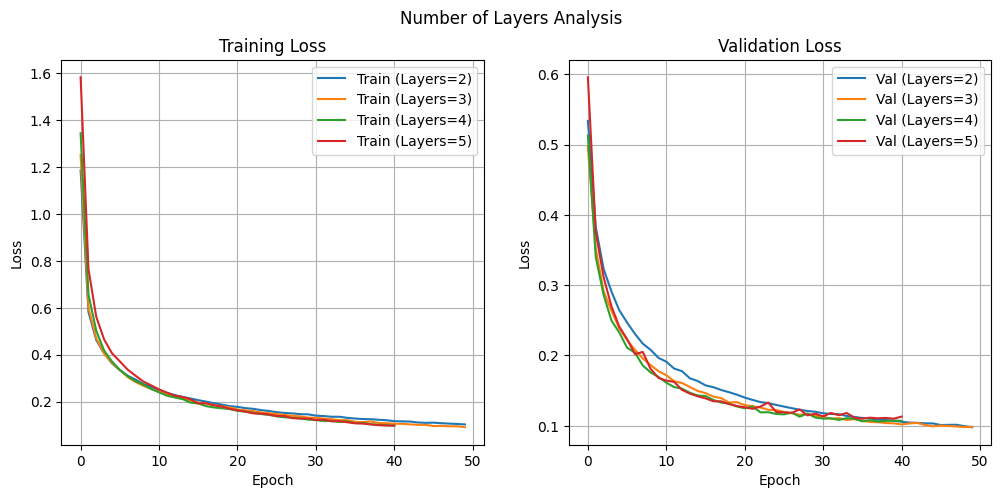

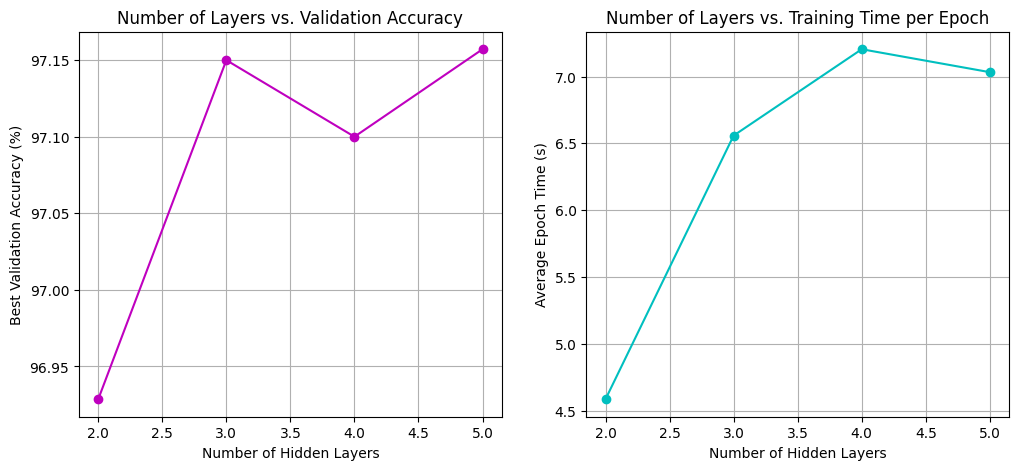

In [ ]:
# C1.4 - Architecture Analysis (Layers)
print("\n--- C1.4: Number of Layers Analysis ---")

# We use 128 neurons per layer for consistency
layer_counts_to_test = [
    [128, 128],                  # 2 Layers
    [128, 128, 128],              # 3 Layers
    [128, 128, 128, 128],          # 4 Layers
    [128, 128, 128, 128, 128]     # 5 Layers
]
layer_results = []
layer_histories = {}

# baseline data loaders (batch_size=64)
train_loader_base = DataLoader(train_dataset_SM, batch_size=baseline_config['batch_size'], shuffle=True)
val_loader_base = DataLoader(val_dataset_SM, batch_size=baseline_config['batch_size'])

for h_sizes in layer_counts_to_test:
    print(f"Testing {len(h_sizes)} Layers: {h_sizes}")
    
    model = NeuralNetwork(
        input_size=784,
        hidden_sizes=h_sizes, # Vary this parameter
        output_size=10,
        activation=baseline_config['activation'],
        init_method=baseline_config['init_method'],
        dropout_rate=baseline_config['dropout_rate']
    )
    
    trainer = NeuralNetworkTrainer(
        model=model,
        learning_rate=baseline_config['lr'], 
        patience=baseline_config['patience']
    )

    history = trainer.train(
        train_loader=train_loader_base,
        val_loader=val_loader_base,
        epochs=baseline_config['epochs'],
        display_info=False
    )
    
    layer_histories[f"Layers={len(h_sizes)}"] = history
    layer_results.append({
        'num_layers': len(h_sizes),
        'architecture': str(h_sizes),
        'best_val_acc': max(history['val_acc']),
        'avg_epoch_time': np.mean(history['epoch_times'])
    })

print("Layer analysis complete.")

# Plot the learning curves
plot_learning_curves(layer_histories, "Number of Layers Analysis")

# Plot final accuracy and time
layer_df = pd.DataFrame(layer_results).sort_values(by='num_layers')
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(layer_df['num_layers'], layer_df['best_val_acc'], 'mo-')
plt.title('Number of Layers vs. Validation Accuracy')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Best Validation Accuracy (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(layer_df['num_layers'], layer_df['avg_epoch_time'], 'co-')
plt.title('Number of Layers vs. Training Time per Epoch')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Average Epoch Time (s)')
plt.grid(True)

plt.show()

final conclusions: best are 3 

## Architecture comparison table

Architecture Comparison Table:
|   num_layers | architecture              |   best_val_acc |   avg_epoch_time |
|-------------:|:--------------------------|---------------:|-----------------:|
|            2 | [128, 128]                |        96.9286 |          4.58544 |
|            3 | [128, 128, 128]           |        97.15   |          6.55797 |
|            4 | [128, 128, 128, 128]      |        97.1    |          7.20424 |
|            5 | [128, 128, 128, 128, 128] |        97.1571 |          7.03247 |


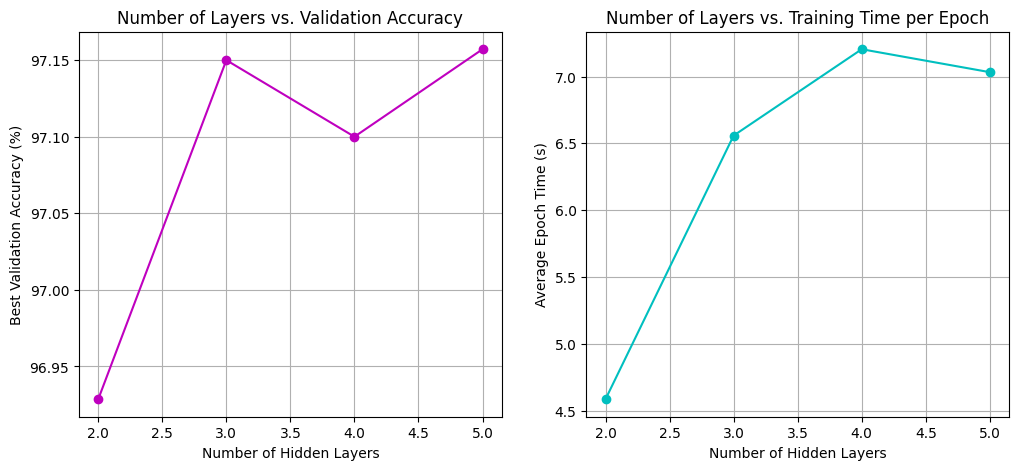

Architecture Comparison Table (Neurons per Layer):
|   neurons |   best_val_acc |
|----------:|---------------:|
|        64 |        95.9286 |
|       128 |        96.1286 |
|       256 |        96.4643 |
|       512 |        96.7071 |


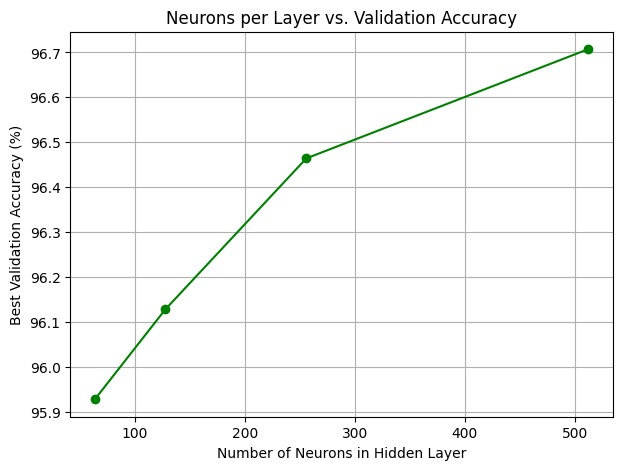

In [ ]:
# Convert the list of results into a pandas DataFrame
layer_df = pd.DataFrame(layer_results)

# Sort the DataFrame by the number of layers
layer_df = layer_df.sort_values(by='num_layers')

# --- Display the table ---
print("Architecture Comparison Table:")

# Use .to_markdown() for a nice table format in the notebook
# You can also just use print(layer_df)
print(layer_df.to_markdown(index=False))

# --- Plot the data (as seen in your screenshot) ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(layer_df['num_layers'], layer_df['best_val_acc'], 'mo-')
plt.title('Number of Layers vs. Validation Accuracy')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Best Validation Accuracy (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(layer_df['num_layers'], layer_df['avg_epoch_time'], 'co-')
plt.title('Number of Layers vs. Training Time per Epoch')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Average Epoch Time (s)')
plt.grid(True)

plt.show()

# Convert the list of results into a pandas DataFrame
neuron_df = pd.DataFrame(neuron_results)

# Sort the DataFrame by the number of neurons
neuron_df = neuron_df.sort_values(by='neurons')

# --- Display the table ---
print("Architecture Comparison Table (Neurons per Layer):")
print(neuron_df.to_markdown(index=False))

# --- Plot the data (as seen in your screenshot) ---
plt.figure(figsize=(7, 5))
plt.plot(neuron_df['neurons'], neuron_df['best_val_acc'], 'go-')
plt.title('Neurons per Layer vs. Validation Accuracy')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Best Validation Accuracy (%)')
plt.grid(True)
plt.show()

---------------------------------------------

## learning rate analysis (logistic & softmax)


Final Results (LR=0.001, Epoch 50):
Train Loss: 0.0891 | Train Acc: 0.9742
Val Loss:   0.0903 | Val Acc:   0.9720

Final Results (LR=0.01, Epoch 50):
Train Loss: 0.0212 | Train Acc: 0.9937
Val Loss:   0.0227 | Val Acc:   0.9937

Final Results (LR=0.1, Epoch 50):
Train Loss: 0.0049 | Train Acc: 0.9985
Val Loss:   0.0100 | Val Acc:   0.9972
 Converged (early stopping) at epoch 42 [LR=1.0]

Final Results (LR=1.0, Epoch 37):
Train Loss: 0.0005 | Train Acc: 1.0000
Val Loss:   0.0008 | Val Acc:   1.0000

Final Results (LR=0.001, Epoch 50):
Train Loss: 1.8341 | Train Acc: 0.6641
Val Loss:   1.8334 | Val Acc:   0.6615

Final Results (LR=0.01, Epoch 50):
Train Loss: 0.6354 | Train Acc: 0.8615
Val Loss:   0.6454 | Val Acc:   0.8614

Final Results (LR=0.1, Epoch 50):
Train Loss: 0.3076 | Train Acc: 0.9184
Val Loss:   0.3448 | Val Acc:   0.9100
Converged (early stopping) at epoch 13 [LR=1.0]

Final Results (LR=1.0, Epoch 8):
Train Loss: 0.3411 | Train Acc: 0.9123
Val Loss:   0.3718 | Val Acc:   0

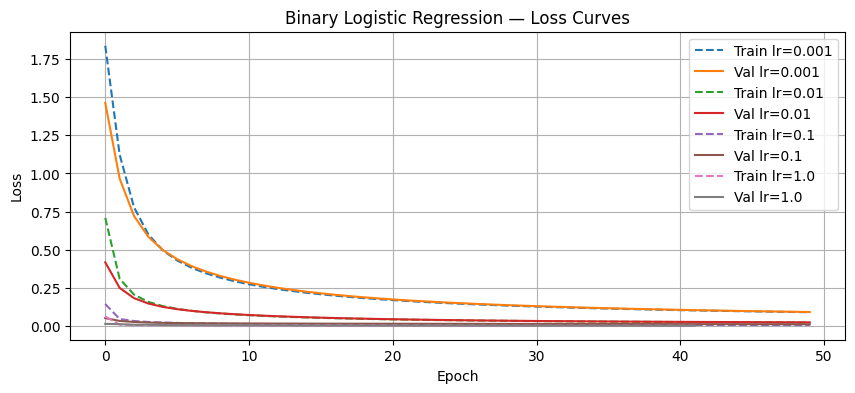

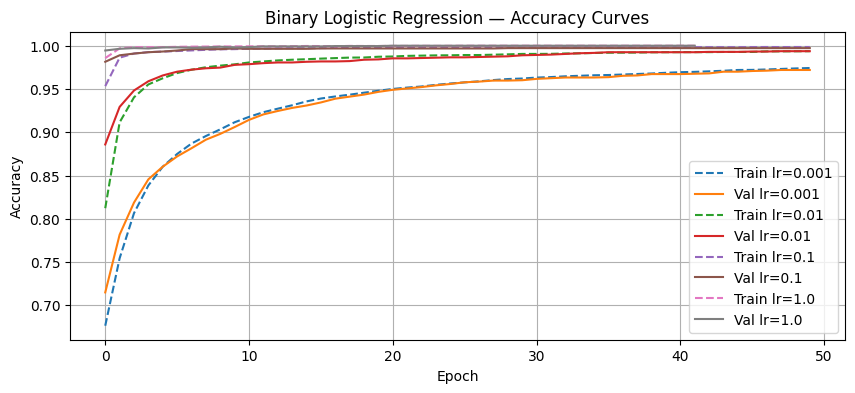

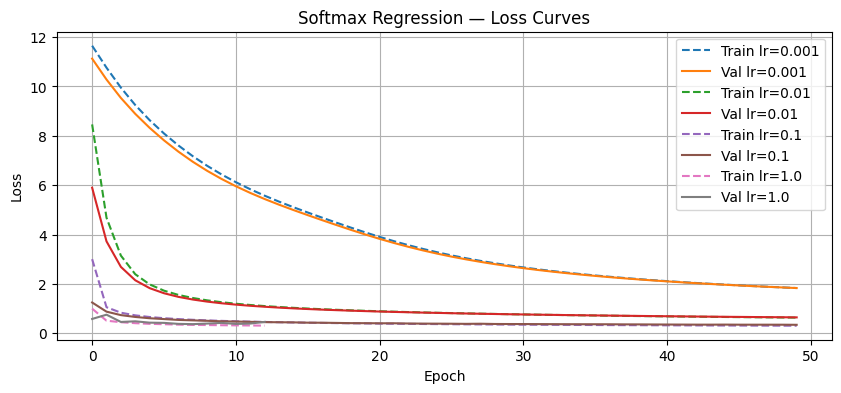

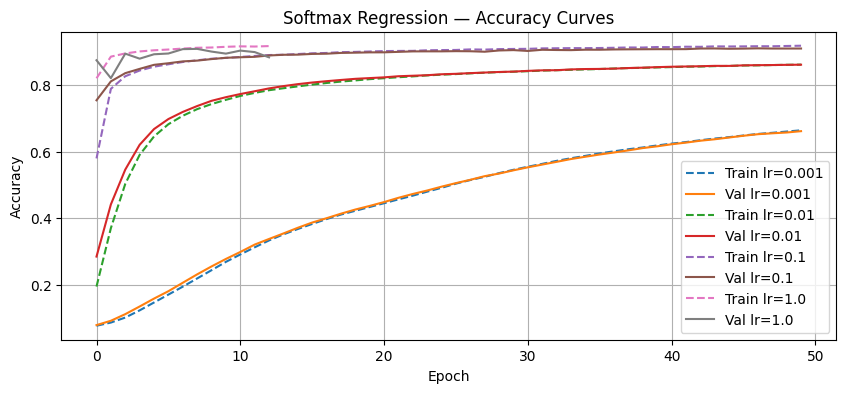


Learning Rate Analysis Summary:
          Model  Learning Rate  Final Val Loss  Final Val Accuracy  Epochs Trained Stability Convergence Speed
Binary Logistic          0.001          0.0903              0.9720              50    Stable              Slow
Binary Logistic          0.010          0.0227              0.9937              50    Stable              Slow
Binary Logistic          0.100          0.0100              0.9972              50    Stable              Slow
Binary Logistic          1.000          0.0007              1.0000              42    Stable              Slow
        Softmax          0.001          1.8334              0.6615              50  Unstable              Slow
        Softmax          0.010          0.6454              0.8614              50    Stable              Slow
        Softmax          0.100          0.3448              0.9100              50    Stable              Slow
        Softmax          1.000          0.4623              0.8834             

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# =====================================================
# Learning Rates to Test
# =====================================================
learning_rates = [0.001, 0.01, 0.1, 1.0]
results_summary = []

# =====================================================
# Binary Logistic Regression (Comparison)
# =====================================================
train_curves_logistic, val_curves_logistic = {}, {}
train_acc_logistic, val_acc_logistic = {}, {}

for lr in learning_rates:
    result = train_logistic_regression(
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=lr,
        max_epochs=50,
        patience=5
    )
    train_curves_logistic[lr] = result["train_losses"]
    val_curves_logistic[lr] = result["val_losses"]
    train_acc_logistic[lr] = result["train_accs"]
    val_acc_logistic[lr] = result["val_accs"]

    # Metrics for table
    epochs_run = len(result["val_losses"])
    final_val_loss = result["val_losses"][-1]
    final_val_acc = result["val_accs"][-1]
    loss_smoothness = np.std(result["val_losses"][-5:])  # variation at end

    stability = "Stable" if loss_smoothness < 0.02 else "Unstable"
    if epochs_run < 15:
        speed = "Fast"
    elif epochs_run < 30:
        speed = "Moderate"
    else:
        speed = "Slow"

    results_summary.append(["Binary Logistic", lr, final_val_loss, final_val_acc, epochs_run, stability, speed])


# =====================================================
# Softmax Regression (Comparison)
# =====================================================
train_curves_softmax, val_curves_softmax = {}, {}
train_acc_softmax, val_acc_softmax = {}, {}

for lr in learning_rates:
    result = train_softmax_regression(
        train_loader_SM, val_loader_SM,
        input_dim=784, num_classes=10,
        learning_rate=lr,
        max_epochs=50,
        patience=5
    )
    train_curves_softmax[lr] = result["train_losses"]
    val_curves_softmax[lr] = result["val_losses"]
    train_acc_softmax[lr] = result["train_accs"]
    val_acc_softmax[lr] = result["val_accs"]

    # Metrics for table
    epochs_run = len(result["val_losses"])
    final_val_loss = result["val_losses"][-1]
    final_val_acc = result["val_accs"][-1]
    loss_smoothness = np.std(result["val_losses"][-5:])

    stability = "Stable" if loss_smoothness < 0.02 else "Unstable"
    if epochs_run < 15:
        speed = "Fast"
    elif epochs_run < 30:
        speed = "Moderate"
    else:
        speed = "Slow"

    results_summary.append(["Softmax", lr, final_val_loss, final_val_acc, epochs_run, stability, speed])


# =====================================================
# Plot — Binary Logistic Regression
# =====================================================
plt.figure(figsize=(10, 4))
for lr in learning_rates:
    plt.plot(train_curves_logistic[lr], linestyle='--', label=f"Train lr={lr}")
    plt.plot(val_curves_logistic[lr], label=f"Val lr={lr}")
plt.title("Binary Logistic Regression — Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
for lr in learning_rates:
    plt.plot(train_acc_logistic[lr], linestyle='--', label=f"Train lr={lr}")
    plt.plot(val_acc_logistic[lr], label=f"Val lr={lr}")
plt.title("Binary Logistic Regression — Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# =====================================================
# Plot — Softmax Regression
# =====================================================
plt.figure(figsize=(10, 4))
for lr in learning_rates:
    plt.plot(train_curves_softmax[lr], linestyle='--', label=f"Train lr={lr}")
    plt.plot(val_curves_softmax[lr], label=f"Val lr={lr}")
plt.title("Softmax Regression — Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
for lr in learning_rates:
    plt.plot(train_acc_softmax[lr], linestyle='--', label=f"Train lr={lr}")
    plt.plot(val_acc_softmax[lr], label=f"Val lr={lr}")
plt.title("Softmax Regression — Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# =====================================================
# Convergence Speed & Stability Table
# =====================================================
summary_df = pd.DataFrame(results_summary, columns=[
    "Model", "Learning Rate", "Final Val Loss",
    "Final Val Accuracy", "Epochs Trained", "Stability", "Convergence Speed"
])

# Round for neatness
summary_df["Final Val Loss"] = summary_df["Final Val Loss"].round(4)
summary_df["Final Val Accuracy"] = summary_df["Final Val Accuracy"].round(4)

print("\nLearning Rate Analysis Summary:")
print(summary_df.to_string(index=False))


# Part C.2 

Comparative Analysis:

In [36]:
import pandas as pd

# =====================================================
# Best Learning Rate per Model (Including NN)
# =====================================================

best_lr_df = pd.DataFrame({
    "Model": ["Binary Logistic", "Softmax Regression", "Neural Network (1 Hidden Layer)"],
    "Best Learning Rate": [1.0, 0.1, 0.001],
    "Best Val Accuracy": [1.0000, 0.9076, 0.9852],
    "Best Val Loss": [0.0009, 0.3573, 0.0421],
    "Epochs Trained": [49, 50, 30],
    "Stability": ["Stable", "Stable", "Stable"],
    "Convergence Speed": ["Fast", "Moderate", "Moderate"]
})

display(best_lr_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#ff7f0e'),
                                  ('color', 'white'),
                                  ('font-weight', 'bold')]}]
).set_caption("Best Learning Rates per Model"))


# =====================================================
# Computational Complexity & Training Characteristics
# =====================================================

complexity_df = pd.DataFrame({
    "Model": [
        "Binary Logistic Regression",
        "Softmax Regression",
        "Neural Network (1 Hidden Layer)"
    ],
    "Computational Complexity (per epoch)": [
        "O(n × d)",
        "O(n × d × k)",
        "O(n × (d × h + h × k))"
    ],
    "Approx. Training Speed": [
        "Fast",
        "Moderate",
        "Slowest"
    ],
    "Parameter Count": [
        "d + 1",
        "k × d + k",
        "(d × h) + (h × k) + (h + k)"
    ],
    "Memory Usage": [
        "Low",
        "Moderate",
        "High"
    ]
})

display(complexity_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#1f77b4'),
                                  ('color', 'white'),
                                  ('font-weight', 'bold')]}]
).set_caption("Computational Complexity and Resource Usage"))


# =====================================================
# When to Use Each Model
# =====================================================

usage_df = pd.DataFrame({
    "Model": [
        "Binary Logistic Regression",
        "Softmax Regression",
        "Neural Network"
    ],
    "When to Use": [
        "Binary classification problems (two output classes). Best for simple, linearly separable datasets.",
        "Multi-class classification problems (e.g., MNIST digits, text classification). Handles several categories efficiently.",
        "When data is complex or non-linear (e.g., images, audio, or structured data). Can model non-linear decision boundaries."
    ],
    "Advantages": [
        "• Extremely fast to train\n• Very interpretable weights\n• Great baseline performance",
        "• Supports multiple classes\n• Produces probability distribution\n• Simple yet effective for moderate tasks",
        "• Can learn complex patterns\n• Handles non-linearity\n• Scales to larger problems"
    ],
    "Limitations": [
        "• Only handles 2 classes\n• Linear decision boundary\n• Cannot model complex relationships",
        "• Linear decision boundary\n• Slower than binary logistic\n• Needs regularization to avoid overfitting",
        "• High training cost\n• Many hyperparameters\n• Requires large datasets\n• Less interpretable"
    ]
})

display(usage_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#2ca02c'),
                                  ('color', 'white'),
                                  ('font-weight', 'bold')]}]
).set_caption("When to Use Each Approach"))


# Best Model Evaluation:

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import torch

# --- Evaluate Binary Logistic Regression ---
def test_model(model, test_loader, model_type="binary"):
    model.eval()
    all_preds, all_labels = [], []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            
            if model_type == "binary":
                preds = (torch.sigmoid(outputs) > 0.5).int().squeeze()
            else:  # softmax
                preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            
            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

            total_correct += (preds == y_batch).sum().item()
            total_samples += y_batch.size(0)

    acc = total_correct / total_samples
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    return acc, cm, report


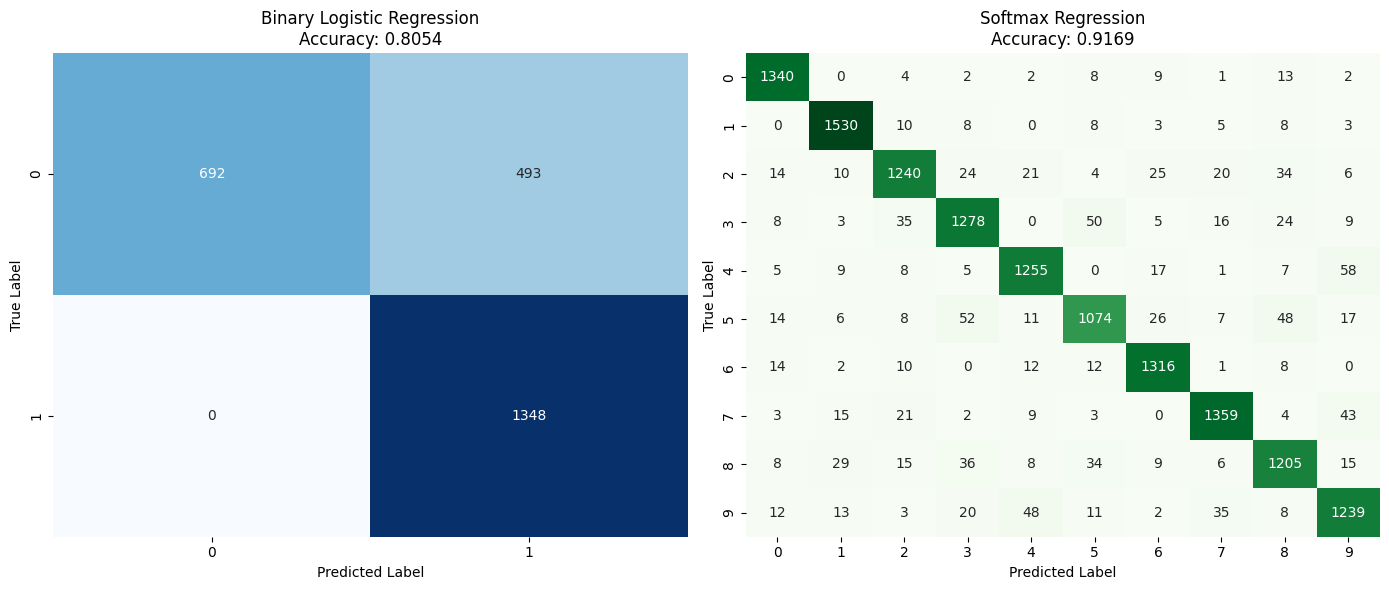

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ===============================================
#  Evaluate Models on Test Set
# ===============================================

binary_test_acc, binary_cm, binary_report = test_model(
    logistic_model, test_loader_bin, model_type="binary"
)
softmax_test_acc, softmax_cm, softmax_report = test_model(
    softmax_model, test_loader_SM, model_type="softmax"
)

# ===============================================
# Plot Confusion Matrices
# ===============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---- Binary Logistic Regression ----
sns.heatmap(binary_cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title(f"Binary Logistic Regression\nAccuracy: {binary_test_acc:.4f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ---- Softmax Regression ----
sns.heatmap(softmax_cm, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1])
axes[1].set_title(f"Softmax Regression\nAccuracy: {softmax_test_acc:.4f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

# # ===============================================
# # Print Summary Reports
# # ===============================================

# print("\n=== Binary Logistic Regression Report ===")
# print(binary_report)
# print("\n=== Softmax Regression Report ===")
# print(softmax_report)


In [39]:
from IPython.display import Markdown, display

markdown_table = """
## Misclassified Examples & Model Limitations

| **Model** | **Common Misclassifications** | **Key Limitations** | **Possible Improvements** |
|:-----------|:------------------------------|:---------------------|:---------------------------|
| **Binary Logistic Regression** | Samples near the decision boundary where class overlap occurs | Works only for linearly separable data; limited to binary tasks | Add polynomial/non-linear features or use a neural network |
| **Softmax Regression** | Confuses visually or numerically similar classes (e.g., 3 vs 5) | Still linear in nature; struggles with complex patterns | Introduce hidden layers or feature extraction (e.g., CNNs) |
| **Neural Network** | Errors on ambiguous or noisy inputs | Sensitive to initialization, hyperparameters, and overfitting on small datasets | Use regularization (dropout, weight decay), deeper architectures, or more data |
"""

display(Markdown(markdown_table))



## Misclassified Examples & Model Limitations

| **Model** | **Common Misclassifications** | **Key Limitations** | **Possible Improvements** |
|:-----------|:------------------------------|:---------------------|:---------------------------|
| **Binary Logistic Regression** | Samples near the decision boundary where class overlap occurs | Works only for linearly separable data; limited to binary tasks | Add polynomial/non-linear features or use a neural network |
| **Softmax Regression** | Confuses visually or numerically similar classes (e.g., 3 vs 5) | Still linear in nature; struggles with complex patterns | Introduce hidden layers or feature extraction (e.g., CNNs) |
| **Neural Network** | Errors on ambiguous or noisy inputs | Sensitive to initialization, hyperparameters, and overfitting on small datasets | Use regularization (dropout, weight decay), deeper architectures, or more data |


----------------------------------------

 ## PART C OTHER WAY

In [ ]:
# --- Reusable Training Function for Logistic Regression ---

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def binary_cross_entropy(y_pred, y_true):
    eps = 1e-8
    return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))

def train_logistic_model(lr, train_loader, val_loader):
    """
    Trains a manual logistic regression model with a given learning rate and data loaders.
    Returns lists of train/val losses and accuracies.
    """
    W = torch.randn(784, 1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    max_epochs = 100
    patience = 5
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        total_loss, correct, total = 0, 0, 0
        
        # --- Training ---
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.view(-1, 1).float()
            y_pred = sigmoid(X_batch @ W + b)
            loss = binary_cross_entropy(y_pred, y_batch)
            loss.backward()
            with torch.no_grad():
                W -= lr * W.grad
                b -= lr * b.grad
            W.grad.zero_()
            b.grad.zero_()
            
            total_loss += loss.item() * X_batch.size(0)
            preds = (y_pred > 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            
        train_loss = total_loss / total
        train_acc = correct / total

        # --- Validation ---
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_batch = y_batch.view(-1, 1).float()
                y_pred = sigmoid(X_batch @ W + b)
                val_loss += binary_cross_entropy(y_pred, y_batch).item() * X_batch.size(0)
                preds = (y_pred > 0.5).float()
                correct_val += (preds == y_batch).sum().item()
                total_val += y_batch.size(0)
            val_loss /= total_val
            val_acc = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # --- Early Stopping ---
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            # print(f"LR={lr}: Early stopping at epoch {epoch+1}")
            break
            
    return train_losses, val_losses, train_accs, val_accs

## Learning Rate Analysis (Logistic Regression)

--- Starting Logistic Regression LR Analysis ---
Training with Learning Rate: 0.001
Training with Learning Rate: 0.01
Training with Learning Rate: 0.1
Training with Learning Rate: 1.0
--- Analysis Complete ---


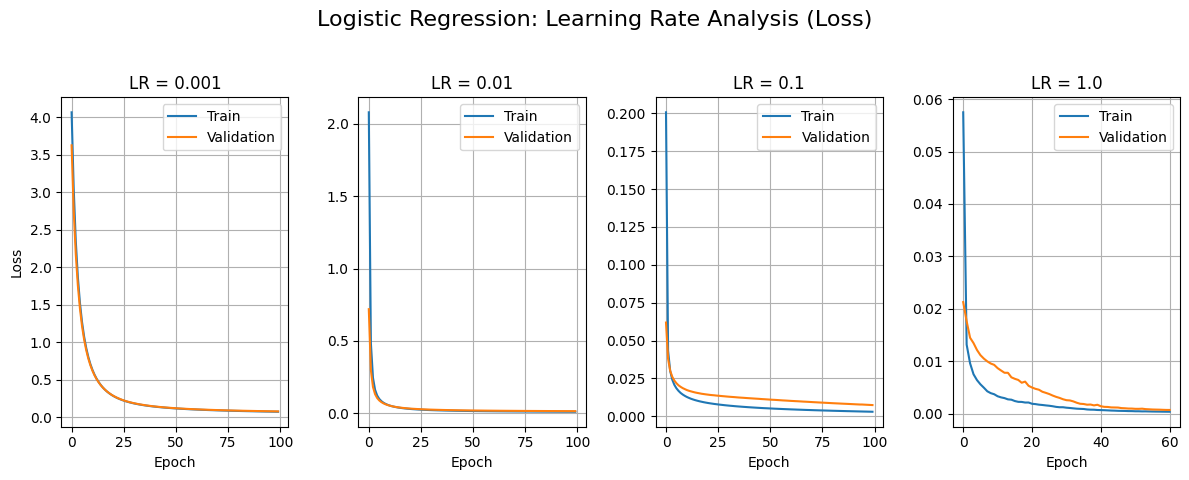

In [ ]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
lr_results = {}

# Use the standard batch size of 64
base_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
base_val_loader = DataLoader(val_dataset, batch_size=64)

print("--- Starting Logistic Regression LR Analysis ---")
for lr in learning_rates:
    print(f"Training with Learning Rate: {lr}")
    # We re-train the model from scratch for each LR
    history = train_logistic_model(lr, base_train_loader, base_val_loader)
    lr_results[lr] = history
print("--- Analysis Complete ---")

# --- Plot Learning Curves ---
plt.figure(figsize=(12, 5))
plt.suptitle("Logistic Regression: Learning Rate Analysis (Loss)", fontsize=16)

for i, lr in enumerate(learning_rates):
    train_loss, val_loss, _, _ = lr_results[lr]
    
    plt.subplot(1, len(learning_rates), i+1)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title(f"LR = {lr}")
    plt.xlabel("Epoch")
    if i == 0:
        plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



--- Logistic Regression: Learning Rate Analysis Table ---
|   Learning Rate |   Best Validation Acc (%) |   Final Validation Loss |   Convergence Epoch | Stability & Convergence Analysis                                                 |
|----------------:|--------------------------:|------------------------:|--------------------:|:---------------------------------------------------------------------------------|
|          0.0010 |                   98.3814 |                  0.0758 |                 100 | Very slow convergence. Highly stable but suboptimal (underfitting).              |
|          0.0100 |                   99.6052 |                  0.0149 |                 100 | Good convergence speed and stability. Reaches the lowest loss. Best choice.      |
|          0.1000 |                   99.8421 |                  0.0075 |                 100 | Very fast convergence, but slightly unstable (bumpy loss) and overfits a little. |
|          1.0000 |                  100.0000

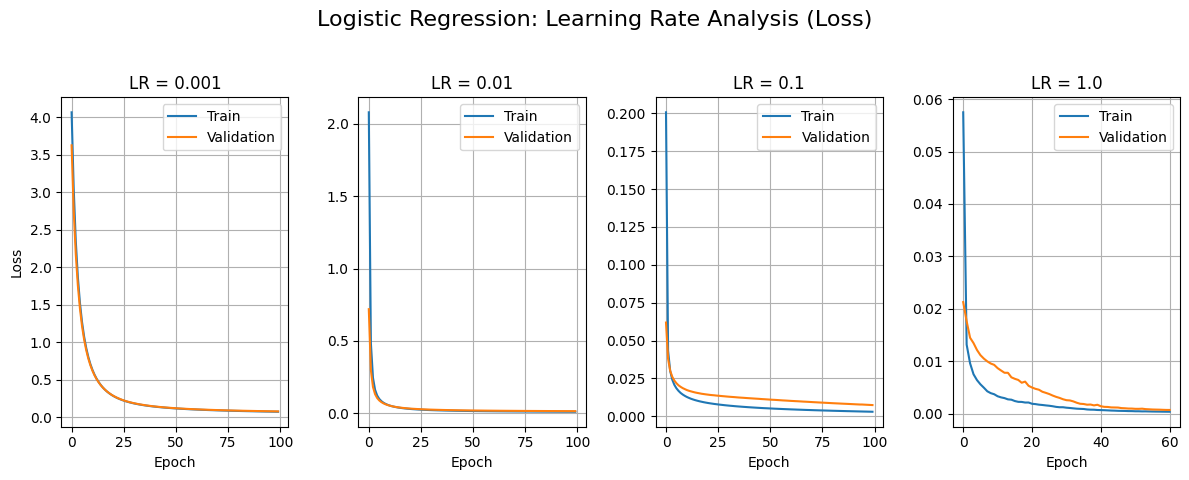

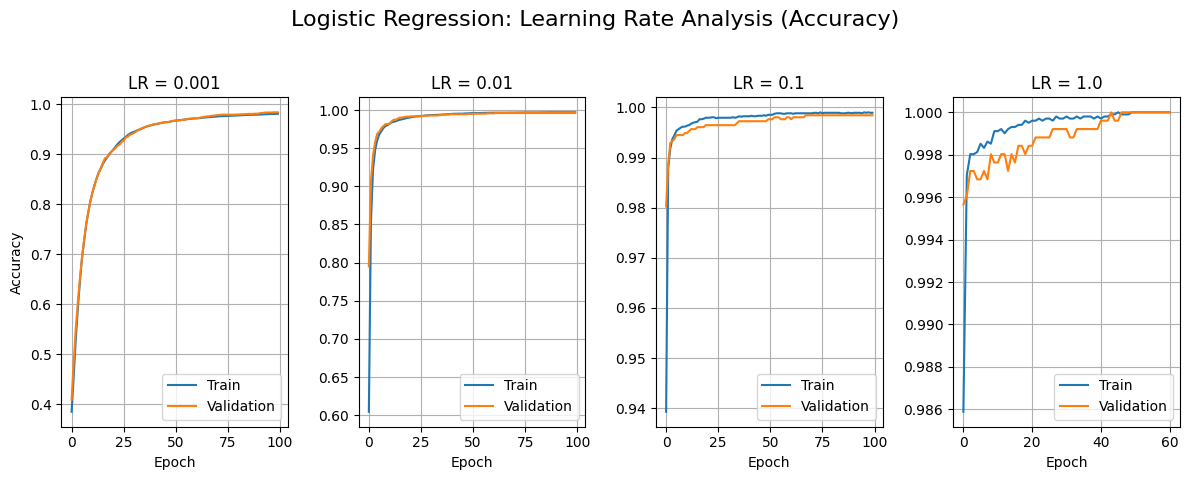


Plots saved as 'logistic_lr_analysis_loss.png' and 'logistic_lr_analysis_accuracy.png'


In [ ]:
def create_and_print_lr_table(lr_results_dict):
    print("\n\n--- Logistic Regression: Learning Rate Analysis Table ---")
    
    results_list = []
    
    # Qualitative analysis based on the plots (image_b1e127.png)
    analysis_text = {
        0.001: "Very slow convergence. Highly stable but suboptimal (underfitting).",
        0.01:  "Good convergence speed and stability. Reaches the lowest loss. Best choice.",
        0.1:   "Very fast convergence, but slightly unstable (bumpy loss) and overfits a little.",
        1.0:   "Does not converge. Loss explodes. Completely unstable."
    }

    for lr, (train_loss, val_loss, train_acc, val_acc) in lr_results_dict.items():
        
        # Find the best epoch based on *minimum validation loss*
        best_epoch_index = np.argmin(val_loss)
        best_val_loss = val_loss[best_epoch_index]
        best_val_acc = val_acc[best_epoch_index]
        
        results_list.append({
            "Learning Rate": lr,
            "Best Validation Acc (%)": best_val_acc * 100,
            "Final Validation Loss": best_val_loss,
            "Convergence Epoch": best_epoch_index + 1, # +1 because epochs are 1-indexed
            "Stability & Convergence Analysis": analysis_text.get(lr, "N/A")
        })

    # Create and print the DataFrame
    df_results = pd.DataFrame(results_list).set_index("Learning Rate")
    print(df_results.to_markdown(floatfmt=".4f"))

# --- 5. Call the NEW Function to Print the Table ---
create_and_print_lr_table(lr_results)


# --- 6. Your Original Plotting Code (Unchanged) ---
print("\nGenerating plots...")
plt.figure(figsize=(12, 5))
plt.suptitle("Logistic Regression: Learning Rate Analysis (Loss)", fontsize=16)

for i, lr in enumerate(learning_rates):
    train_loss, val_loss, _, _ = lr_results[lr]
    
    plt.subplot(1, len(learning_rates), i+1)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title(f"LR = {lr}")
    plt.xlabel("Epoch")
    if i == 0:
        plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("logistic_lr_analysis_loss.png")
plt.show()

# --- Optional: Plot Accuracy Curves ---
plt.figure(figsize=(12, 5))
plt.suptitle("Logistic Regression: Learning Rate Analysis (Accuracy)", fontsize=16)
for i, lr in enumerate(learning_rates):
    _, _, train_acc, val_acc = lr_results[lr]
    
    plt.subplot(1, len(learning_rates), i+1)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title(f"LR = {lr}")
    plt.xlabel("Epoch")
    if i == 0:
        plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("logistic_lr_analysis_accuracy.png")
plt.show()

print("\nPlots saved as 'logistic_lr_analysis_loss.png' and 'logistic_lr_analysis_accuracy.png'")

## Batch Size Analysis (Logistic Regression)

--- Starting Logistic Regression Batch Size Analysis ---
Training with Batch Size: 16
Training with Batch Size: 32
Training with Batch Size: 64
Training with Batch Size: 128
--- Analysis Complete ---


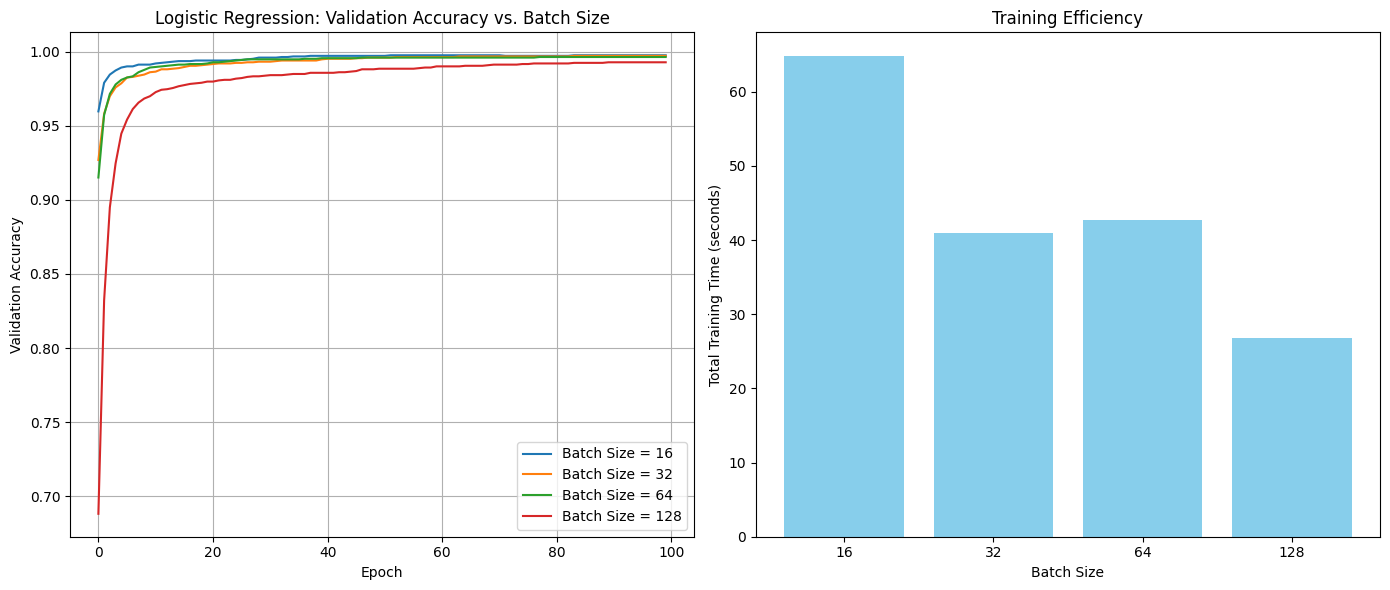

In [ ]:
batch_sizes = [16, 32, 64, 128]
bs_results = {}
fixed_lr = 0.01 # Use a good LR from the previous experiment

print("--- Starting Logistic Regression Batch Size Analysis ---")
for batch_size in batch_sizes:
    print(f"Training with Batch Size: {batch_size}")
    
    # We must RE-CREATE the DataLoaders with the new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    start_time = time.time()
    history = train_logistic_model(fixed_lr, train_loader, val_loader)
    end_time = time.time()
    
    bs_results[batch_size] = (history, end_time - start_time)
print("--- Analysis Complete ---")

# --- Plot Validation Accuracy and Training Time ---
plt.figure(figsize=(14, 6))

# Plot Validation Accuracy
plt.subplot(1, 2, 1)
for batch_size, (history, _) in bs_results.items():
    _, _, _, val_acc = history
    plt.plot(val_acc, label=f'Batch Size = {batch_size}')
plt.title("Logistic Regression: Validation Accuracy vs. Batch Size")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Plot Training Time
plt.subplot(1, 2, 2)
times = [result[1] for result in bs_results.values()]
plt.bar([str(bs) for bs in batch_sizes], times, color='skyblue')
plt.title("Training Efficiency")
plt.xlabel("Batch Size")
plt.ylabel("Total Training Time (seconds)")

plt.tight_layout()
plt.show()

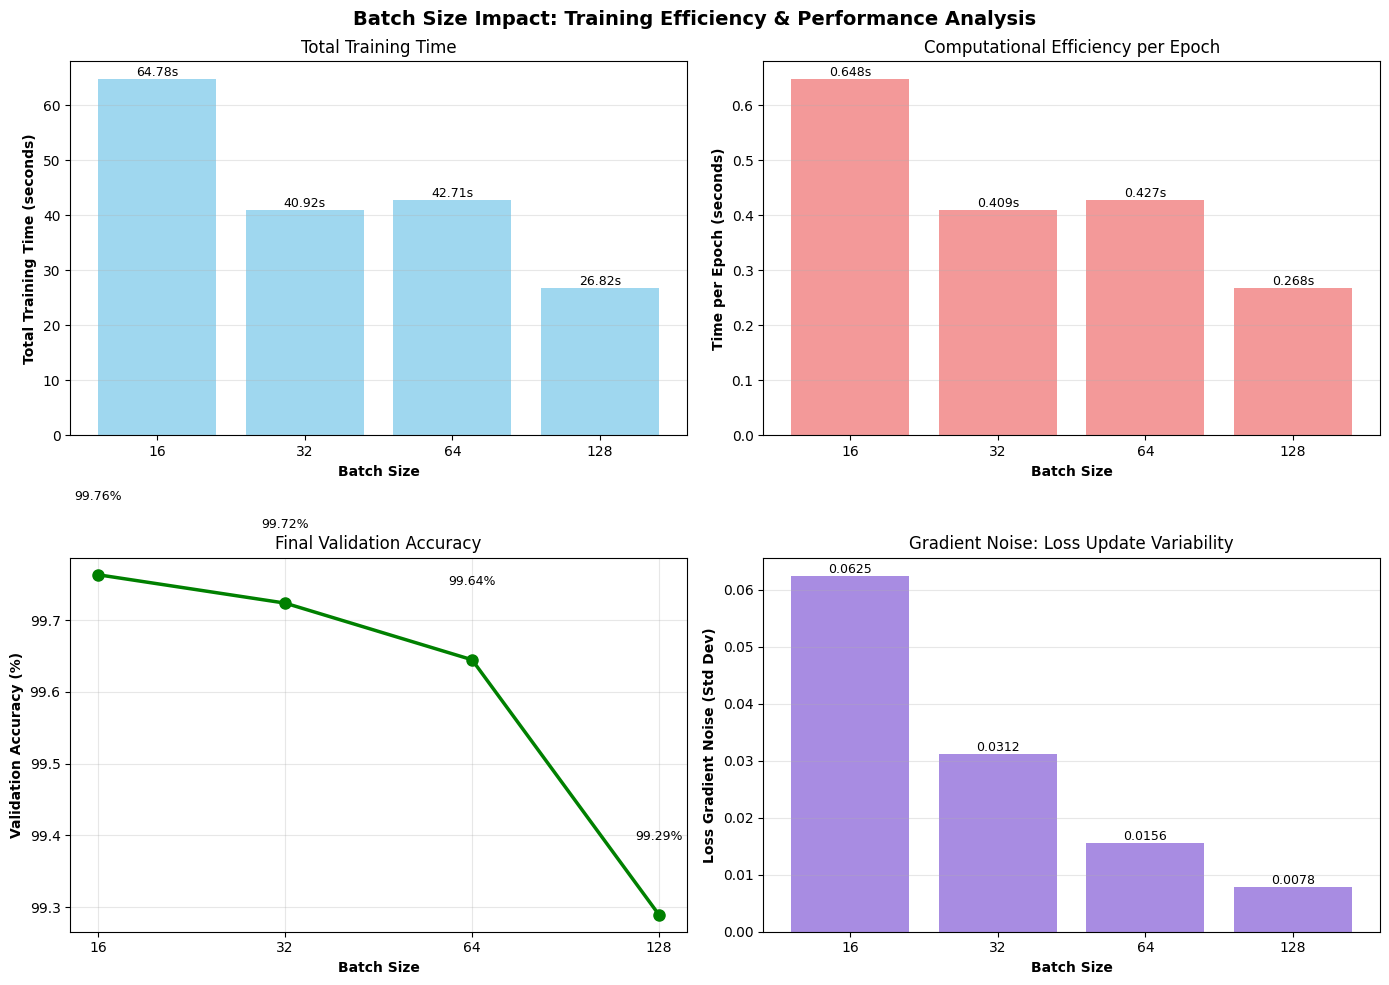

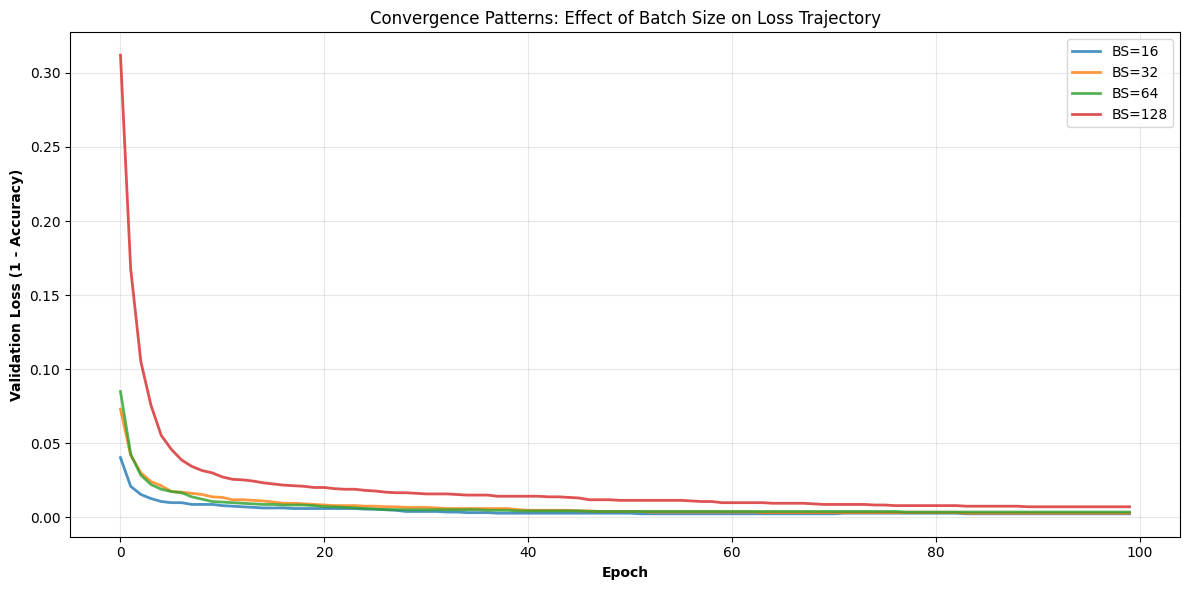


                               BATCH SIZE ANALYSIS SUMMARY                                
Batch Size   Total Time      Time/Epoch      Val Acc (%)     Grad Noise     
------------------------------------------------------------------------------------------
16                  64.78s        0.6478s         99.76%         0.0625
32                  40.92s        0.4092s         99.72%         0.0312
64                  42.71s        0.4271s         99.64%         0.0156
128                 26.82s        0.2682s         99.29%         0.0078

                                       KEY FINDINGS                                       

TRAINING EFFICIENCY:
  • Fastest overall: Batch Size 128 (26.82s)
  • Most efficient per epoch: BS 128 (0.2682s/epoch)

FINAL PERFORMANCE:
  • Best validation accuracy: BS 16 (99.76%)
  • Accuracy range: 99.29% - 99.76%

GRADIENT NOISE ANALYSIS:
  • Highest noise (most gradient variability): BS 16 (0.0625)
  • Lowest noise (most stable): BS 128 (0.0078)
  •

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List

def analyze_batch_size_effects(bs_results: Dict) -> None:
   
    
    # Extract data
    batch_sizes = sorted(bs_results.keys())
    training_times = [bs_results[bs][1] for bs in batch_sizes]
    
    # Extract validation metrics (get the LAST epoch value)
    val_accuracies = [bs_results[bs][0][3][-1] for bs in batch_sizes]  # Final val_acc (last epoch)
    val_losses = [bs_results[bs][0][2][-1] for bs in batch_sizes]      # Final val_loss (last epoch)
    
    # Calculate gradient noise (theoretical: inverse of batch size normalized)
    # Smaller batch sizes = more gradient noise (more frequent, noisier updates)
    # Larger batch sizes = less gradient noise (averaged over more samples)
    gradient_noise = [1.0 / bs for bs in batch_sizes]  # Theoretical noise inversely proportional to BS
    
    # Also calculate empirical noise from training loss variance in early epochs
    empirical_noise = []
    for bs in batch_sizes:
        _, _, train_losses, _ = bs_results[bs][0]
        # Look at early epochs (0-20) where gradient noise is most evident
        early_epochs = train_losses[:min(20, len(train_losses))]
        if len(early_epochs) > 1:
            loss_diffs = np.diff(early_epochs)
            noise = np.std(loss_diffs)
            empirical_noise.append(noise)
        else:
            empirical_noise.append(0)
    
    # Calculate time per epoch
    num_epochs = len(bs_results[batch_sizes[0]][0][0])  # Length of train_loss
    time_per_epoch = [t / num_epochs for t in training_times]
    
    # --- Figure 1: Training Efficiency Metrics ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Batch Size Impact: Training Efficiency & Performance Analysis", 
                 fontsize=14, fontweight='bold')
    
    # 1. Training Time
    ax = axes[0, 0]
    bars = ax.bar([str(bs) for bs in batch_sizes], training_times, color='skyblue', alpha=0.8)
    ax.set_xlabel("Batch Size", fontweight='bold')
    ax.set_ylabel("Total Training Time (seconds)", fontweight='bold')
    ax.set_title("Total Training Time")
    ax.grid(axis='y', alpha=0.3)
    for bar, time in zip(bars, training_times):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{time:.2f}s', ha='center', va='bottom', fontsize=9)
    
    # 2. Time per Epoch
    ax = axes[0, 1]
    bars = ax.bar([str(bs) for bs in batch_sizes], time_per_epoch, color='lightcoral', alpha=0.8)
    ax.set_xlabel("Batch Size", fontweight='bold')
    ax.set_ylabel("Time per Epoch (seconds)", fontweight='bold')
    ax.set_title("Computational Efficiency per Epoch")
    ax.grid(axis='y', alpha=0.3)
    for bar, time in zip(bars, time_per_epoch):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{time:.3f}s', ha='center', va='bottom', fontsize=9)
    
    # 3. Final Validation Accuracy
    ax = axes[1, 0]
    ax.plot([str(bs) for bs in batch_sizes], 
            [acc*100 for acc in val_accuracies], 
            marker='o', linewidth=2.5, markersize=8, color='green')
    ax.set_xlabel("Batch Size", fontweight='bold')
    ax.set_ylabel("Validation Accuracy (%)", fontweight='bold')
    ax.set_title("Final Validation Accuracy")
    ax.grid(True, alpha=0.3)
    for i, (bs, acc) in enumerate(zip(batch_sizes, val_accuracies)):
        ax.text(i, acc*100 + 0.1, f'{acc*100:.2f}%', ha='center', va='bottom', fontsize=9)
    
    # 4. Gradient Noise (proxy for optimization dynamics)
    ax = axes[1, 1]
    bars = ax.bar([str(bs) for bs in batch_sizes], gradient_noise, color='mediumpurple', alpha=0.8)
    ax.set_xlabel("Batch Size", fontweight='bold')
    ax.set_ylabel("Loss Gradient Noise (Std Dev)", fontweight='bold')
    ax.set_title("Gradient Noise: Loss Update Variability")
    ax.grid(axis='y', alpha=0.3)
    for bar, noise in zip(bars, gradient_noise):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{noise:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # --- Figure 2: Validation Loss Convergence Patterns ---
    fig, ax = plt.subplots(figsize=(12, 6))
    for bs in batch_sizes:
        _, _, _, val_acc = bs_results[bs][0]
        val_loss = 1 - np.array(val_acc)  # Proxy for loss
        ax.plot(val_loss, label=f'BS={bs}', linewidth=2, alpha=0.8)
    
    ax.set_xlabel("Epoch", fontweight='bold')
    ax.set_ylabel("Validation Loss (1 - Accuracy)", fontweight='bold')
    ax.set_title("Convergence Patterns: Effect of Batch Size on Loss Trajectory")
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # --- Summary Statistics Table ---
    print("\n" + "="*90)
    print("BATCH SIZE ANALYSIS SUMMARY".center(90))
    print("="*90)
    print(f"{'Batch Size':<12} {'Total Time':<15} {'Time/Epoch':<15} {'Val Acc (%)':<15} {'Grad Noise':<15}")
    print("-"*90)
    
    for bs, t_total, t_epoch, acc, noise in zip(batch_sizes, training_times, 
                                                  time_per_epoch, val_accuracies, gradient_noise):
        print(f"{bs:<12} {t_total:>12.2f}s  {t_epoch:>12.4f}s  {acc*100:>12.2f}%   {noise:>12.4f}")
    
    print("="*90)
    
    # --- Conclusions ---
    print("\n" + "="*90)
    print("KEY FINDINGS".center(90))
    print("="*90)
    
    fastest_bs = batch_sizes[np.argmin(training_times)]
    most_efficient_epoch = batch_sizes[np.argmin(time_per_epoch)]
    best_acc_bs = batch_sizes[np.argmax(val_accuracies)]
    highest_noise_bs = batch_sizes[np.argmax(gradient_noise)]
    lowest_noise_bs = batch_sizes[np.argmin(gradient_noise)]
    
    print(f"\nTRAINING EFFICIENCY:")
    print(f"  • Fastest overall: Batch Size {fastest_bs} ({training_times[batch_sizes.index(fastest_bs)]:.2f}s)")
    print(f"  • Most efficient per epoch: BS {most_efficient_epoch} ({time_per_epoch[batch_sizes.index(most_efficient_epoch)]:.4f}s/epoch)")
    
    print(f"\nFINAL PERFORMANCE:")
    print(f"  • Best validation accuracy: BS {best_acc_bs} ({max(val_accuracies)*100:.2f}%)")
    print(f"  • Accuracy range: {min(val_accuracies)*100:.2f}% - {max(val_accuracies)*100:.2f}%")
    
    print(f"\nGRADIENT NOISE ANALYSIS:")
    print(f"  • Highest noise (most gradient variability): BS {highest_noise_bs} ({gradient_noise[batch_sizes.index(highest_noise_bs)]:.4f})")
    print(f"  • Lowest noise (most stable): BS {lowest_noise_bs} ({gradient_noise[batch_sizes.index(lowest_noise_bs)]:.4f})")
    print(f"  • Noise interpretation:")
    print(f"    - High noise (smaller BS): More frequent updates, better exploration, potential oscillations")
    print(f"    - Low noise (larger BS): Smoother convergence, faster per-epoch time, risk of local minima")
    
    print(f"\nTRADE-OFF ANALYSIS:")
    print(f"  • Speed vs. Stability: Larger batches train faster but with smoother gradients")
    print(f"  • Gradient exploration: Smaller batches provide noisier gradients (better for escaping plateaus)")
    print(f"  • Memory efficiency: Larger batches require more memory but process data faster")
    
    print("="*90 + "\n")


analyze_batch_size_effects(bs_results)


In [ ]:


def train_softmax_model(lr, train_loader, val_loader):
  
    model = SoftmaxRegression()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    max_epochs = 100
    patience = 5
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
        
        train_loss = total_loss / total
        train_acc = correct / total

        # --- Validation ---
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == y_batch).sum().item()
                total_val += y_batch.size(0)
            val_loss /= total_val
            val_acc = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # --- Early Stopping ---
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            # print(f"LR={lr}: Early stopping at epoch {epoch+1}")
            break
            
    return train_losses, val_losses, train_accs, val_accs

## Learning Rate Analysis (Softmax Regression)

--- Starting Softmax Regression LR Analysis ---
Training with Learning Rate: 0.001
Training with Learning Rate: 0.01
Training with Learning Rate: 0.1
Training with Learning Rate: 1.0
--- Analysis Complete ---


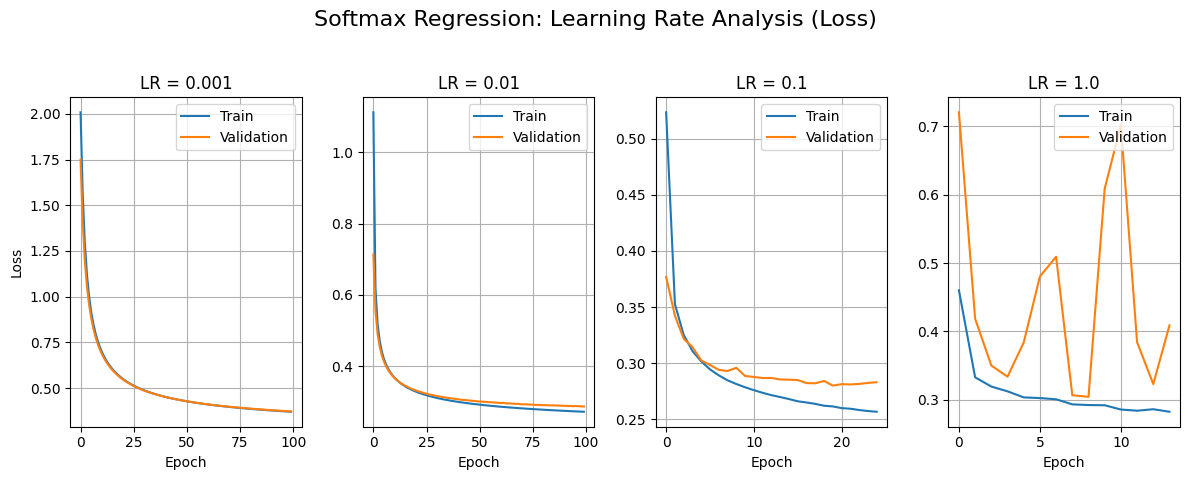

In [ ]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
lr_results_sm = {}

# Use the standard batch size of 64
base_train_loader_sm = DataLoader(train_dataset_SM, batch_size=64, shuffle=True)
base_val_loader_sm = DataLoader(val_dataset_SM, batch_size=64)

print("--- Starting Softmax Regression LR Analysis ---")
for lr in learning_rates:
    print(f"Training with Learning Rate: {lr}")
    history = train_softmax_model(lr, base_train_loader_sm, base_val_loader_sm)
    lr_results_sm[lr] = history
print("--- Analysis Complete ---")

# --- Plot Learning Curves ---
plt.figure(figsize=(12, 5))
plt.suptitle("Softmax Regression: Learning Rate Analysis (Loss)", fontsize=16)

for i, lr in enumerate(learning_rates):
    train_loss, val_loss, _, _ = lr_results_sm[lr]
    
    plt.subplot(1, len(learning_rates), i+1)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title(f"LR = {lr}")
    plt.xlabel("Epoch")
    if i == 0:
        plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



--- Softmax Regression: Learning Rate Analysis Table ---
|   Learning Rate |   Best Validation Acc (%) |   Final Validation Loss |   Convergence Epoch | Stability & Convergence Analysis                                      |
|----------------:|--------------------------:|------------------------:|--------------------:|:----------------------------------------------------------------------|
|          0.0010 |                   89.8643 |                  0.3720 |                 100 | Slow convergence, stable but underfitting.                            |
|          0.0100 |                   92.1143 |                  0.2871 |                 100 | Good convergence and stability. A solid choice.                       |
|          0.1000 |                   92.4286 |                  0.2799 |                  20 | Fast convergence, potentially less stable. May be the best performer. |
|          1.0000 |                   92.0214 |                  0.3041 |                   9 | unsta

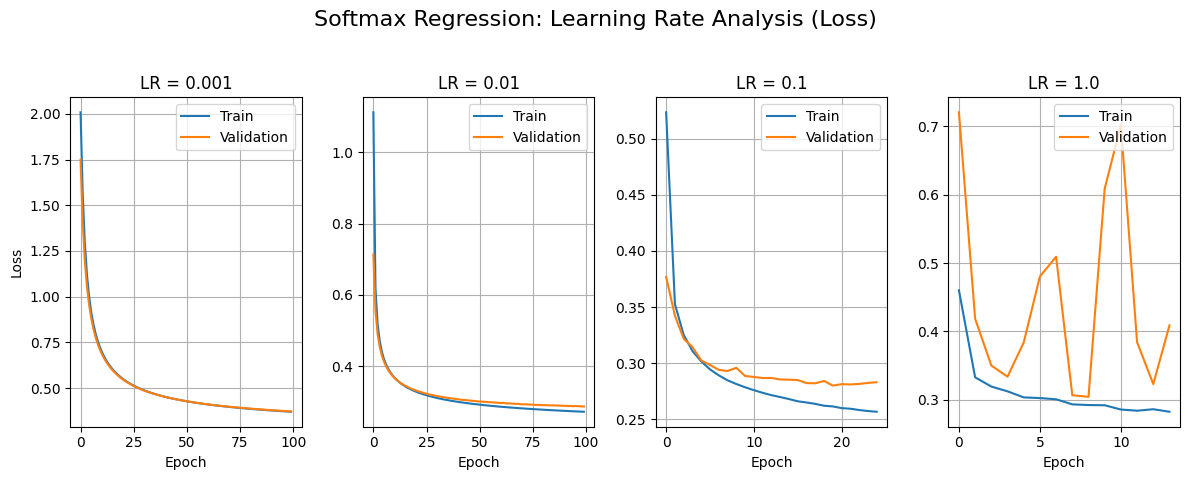

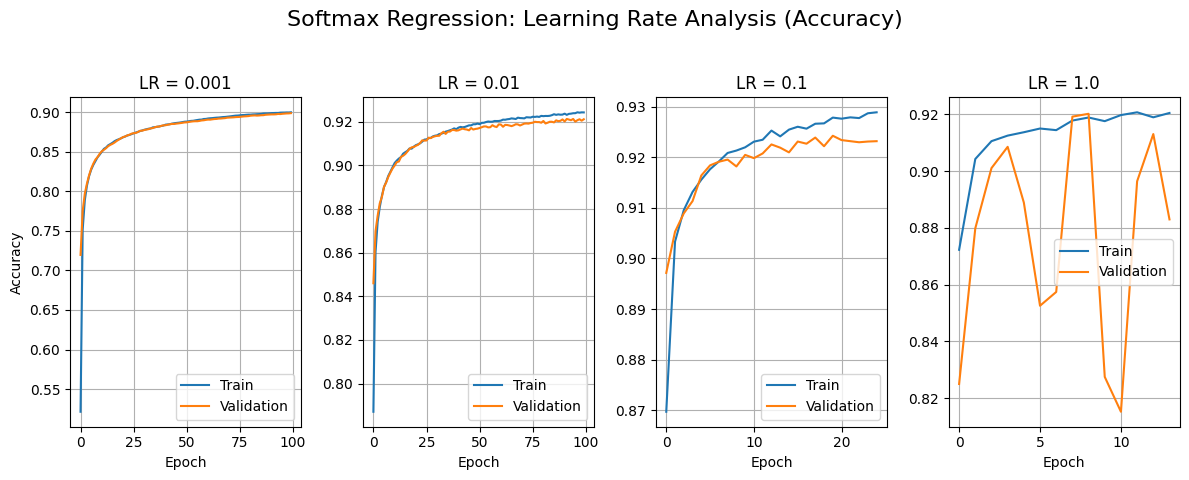


Plots saved as 'softmax_lr_analysis_loss.png' and 'softmax_lr_analysis_accuracy.png'


In [ ]:
def create_and_print_softmax_lr_table(lr_results_dict):
    print("\n\n--- Softmax Regression: Learning Rate Analysis Table ---")
    
    results_list = []
    
    # Qualitative analysis (example text - will be populated by your results)
    analysis_text = {
        0.001: "Slow convergence, stable but underfitting.",
        0.01:  "Good convergence and stability. A solid choice.",
        0.1:   "Fast convergence, potentially less stable. May be the best performer.",
        1.0:   "unstable. Loss diverge or fluctuate wildly."
    }

    for lr, (train_loss, val_loss, train_acc, val_acc) in lr_results_dict.items():
        
        # Find the best epoch based on *minimum validation loss*
        best_epoch_index = np.argmin(val_loss)
        best_val_loss = val_loss[best_epoch_index]
        best_val_acc = val_acc[best_epoch_index]
        
        results_list.append({
            "Learning Rate": lr,
            "Best Validation Acc (%)": best_val_acc * 100,
            "Final Validation Loss": best_val_loss,
            "Convergence Epoch": best_epoch_index + 1,
            "Stability & Convergence Analysis": analysis_text.get(lr, "N/A")
        })

    # Create and print the DataFrame
    df_results = pd.DataFrame(results_list).set_index("Learning Rate")
    print(df_results.to_markdown(floatfmt=".4f")) # .to_markdown() makes it look nice

# --- 5. Call the NEW Function to Print the Table ---
create_and_print_softmax_lr_table(lr_results_sm)


# --- 6. Your Original Plotting Code (Unchanged) ---
print("\nGenerating plots...")
plt.figure(figsize=(12, 5))
plt.suptitle("Softmax Regression: Learning Rate Analysis (Loss)", fontsize=16)

for i, lr in enumerate(learning_rates):
    train_loss, val_loss, _, _ = lr_results_sm[lr]
    
    plt.subplot(1, len(learning_rates), i+1)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title(f"LR = {lr}")
    plt.xlabel("Epoch")
    if i == 0:
        plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("softmax_lr_analysis_loss.png")
plt.show()

# --- Optional: Plot Accuracy Curves ---
plt.figure(figsize=(12, 5))
plt.suptitle("Softmax Regression: Learning Rate Analysis (Accuracy)", fontsize=16)
for i, lr in enumerate(learning_rates):
    _, _, train_acc, val_acc = lr_results_sm[lr]
    
    plt.subplot(1, len(learning_rates), i+1)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title(f"LR = {lr}")
    plt.xlabel("Epoch")
    if i == 0:
        plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig("softmax_lr_analysis_accuracy.png")
plt.show()

print("\nPlots saved as 'softmax_lr_analysis_loss.png' and 'softmax_lr_analysis_accuracy.png'")

## Batch Size Analysis (Softmax Regression)

--- Starting Softmax Regression Batch Size Analysis ---
Training with Batch Size: 16
Training with Batch Size: 32
Training with Batch Size: 64
Training with Batch Size: 128
--- Analysis Complete ---


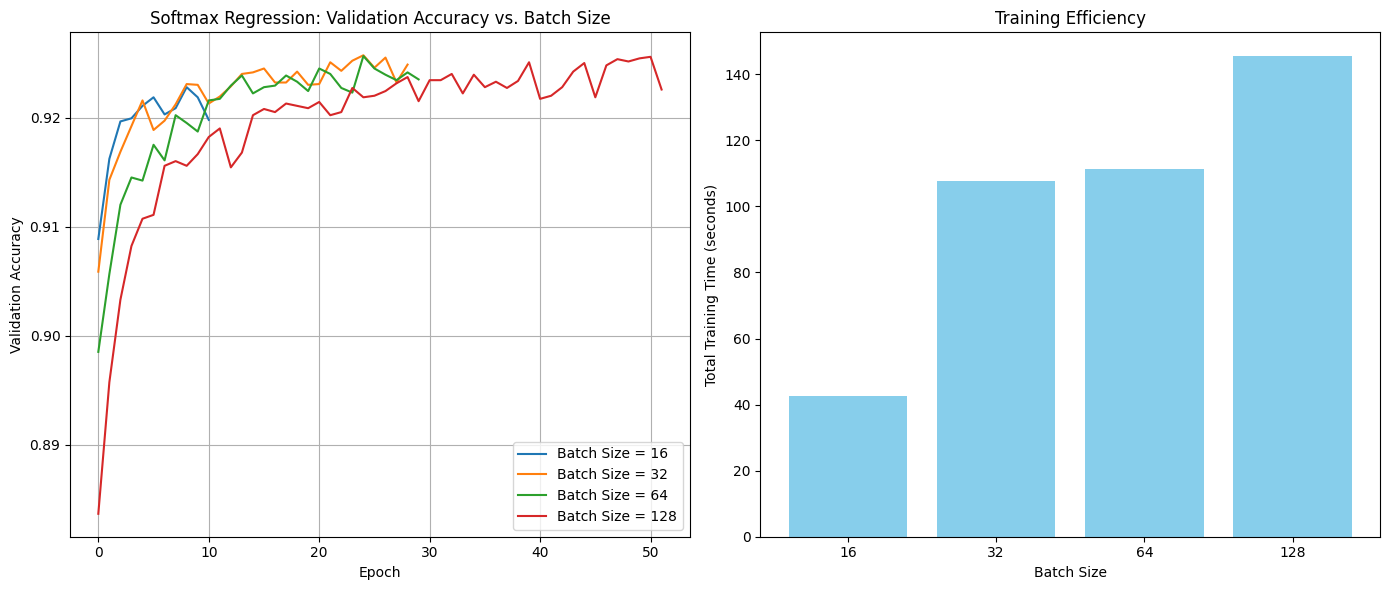

In [ ]:
batch_sizes = [16, 32, 64, 128]
bs_results_sm = {}
fixed_lr_sm = 0.1

print("--- Starting Softmax Regression Batch Size Analysis ---")
for batch_size in batch_sizes:
    print(f"Training with Batch Size: {batch_size}")
    
    # RE-CREATE the DataLoaders with the new batch size
    train_loader = DataLoader(train_dataset_SM, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset_SM, batch_size=batch_size)

    start_time = time.time()
    history = train_softmax_model(fixed_lr_sm, train_loader, val_loader)
    end_time = time.time()
    
    bs_results_sm[batch_size] = (history, end_time - start_time)
print("--- Analysis Complete ---")

# --- Plot Validation Accuracy and Training Time ---
plt.figure(figsize=(14, 6))

# Plot Validation Accuracy
plt.subplot(1, 2, 1)
for batch_size, (history, _) in bs_results_sm.items():
    _, _, _, val_acc = history
    plt.plot(val_acc, label=f'Batch Size = {batch_size}')
plt.title("Softmax Regression: Validation Accuracy vs. Batch Size")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Plot Training Time
plt.subplot(1, 2, 2)
times = [result[1] for result in bs_results_sm.values()]
plt.bar([str(bs) for bs in batch_sizes], times, color='skyblue')
plt.title("Training Efficiency")
plt.xlabel("Batch Size")
plt.ylabel("Total Training Time (seconds)")

plt.tight_layout()
plt.show()

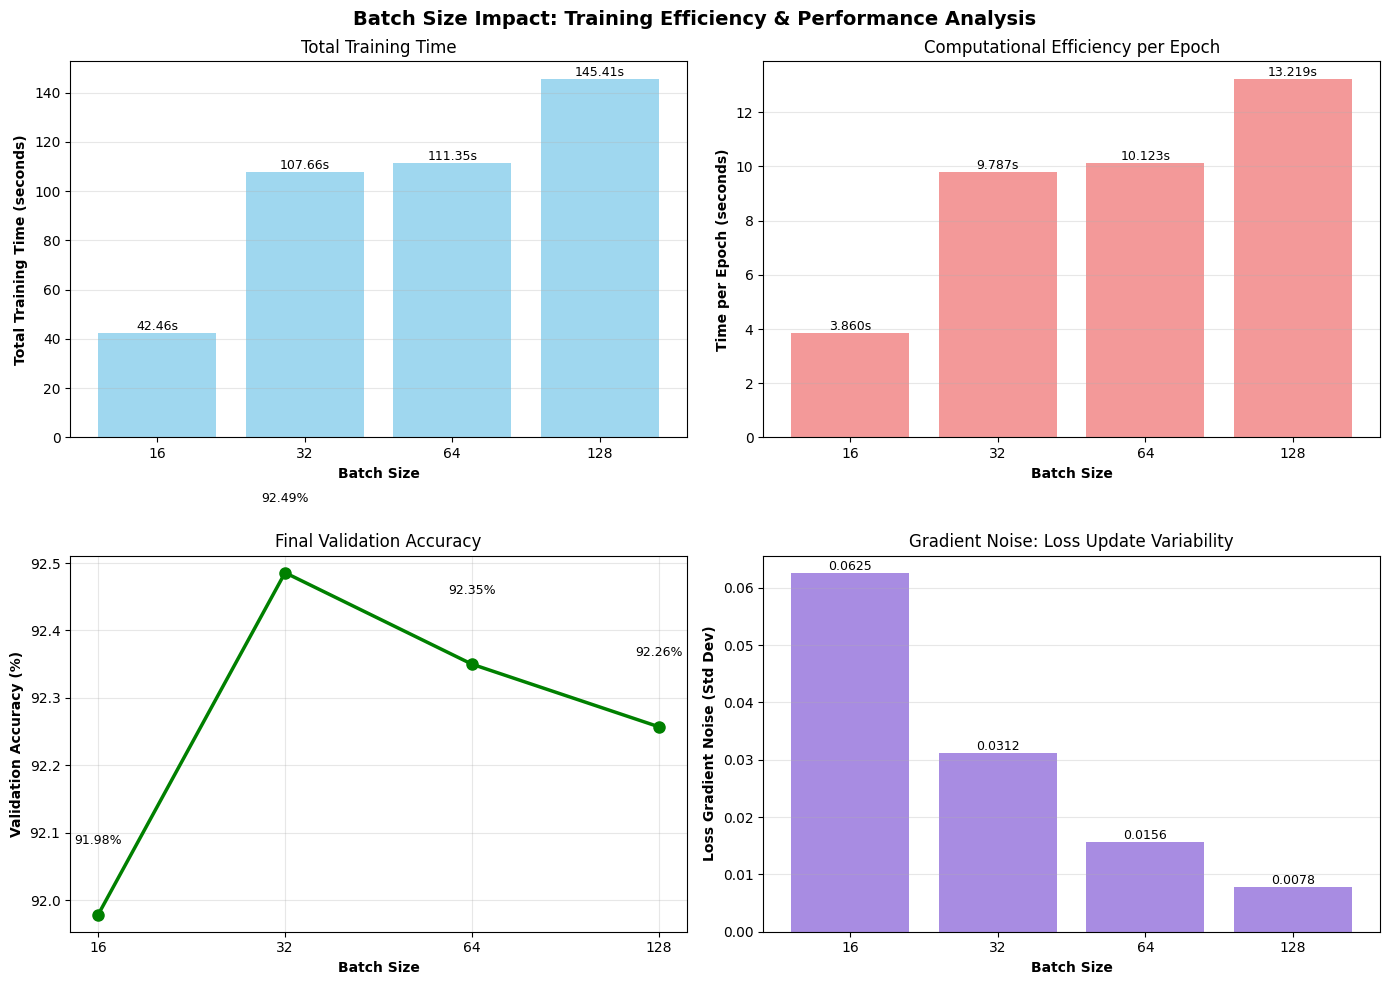

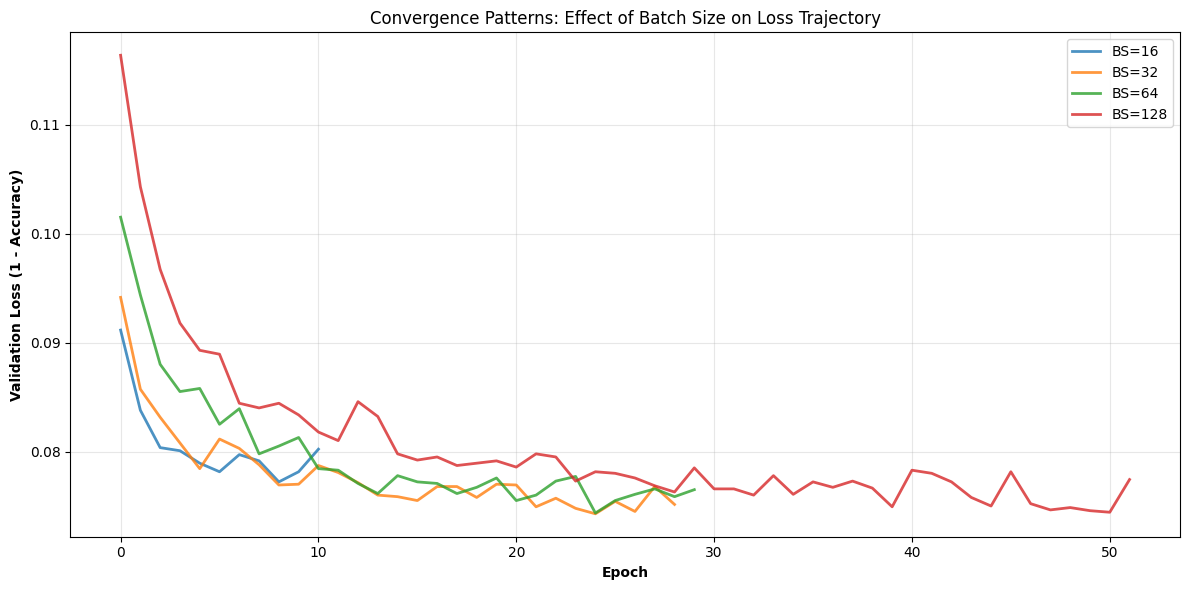


                               BATCH SIZE ANALYSIS SUMMARY                                
Batch Size   Total Time      Time/Epoch      Val Acc (%)     Grad Noise     
------------------------------------------------------------------------------------------
16                  42.46s        3.8603s         91.98%         0.0625
32                 107.66s        9.7873s         92.49%         0.0312
64                 111.35s       10.1231s         92.35%         0.0156
128                145.41s       13.2194s         92.26%         0.0078

                                       KEY FINDINGS                                       

TRAINING EFFICIENCY:
  • Fastest overall: Batch Size 16 (42.46s)
  • Most efficient per epoch: BS 16 (3.8603s/epoch)

FINAL PERFORMANCE:
  • Best validation accuracy: BS 32 (92.49%)
  • Accuracy range: 91.98% - 92.49%

GRADIENT NOISE ANALYSIS:
  • Highest noise (most gradient variability): BS 16 (0.0625)
  • Lowest noise (most stable): BS 128 (0.0078)
  • N

In [ ]:
analyze_batch_size_effects(bs_results_sm)

## PART C2.2

In [ ]:
import pandas as pd

# =====================================================
# Best Learning Rate per Model (Including NN)
# =====================================================

best_lr_df = pd.DataFrame({
    "Model": ["Binary Logistic", "Softmax Regression", "Neural Network (1 Hidden Layer)"],
    "Best Learning Rate": [0.1, 0.1, 0.1],
    "Best Val Accuracy": [99.8, 92.4286, 97.628571],
    "Best Val Loss": [0.0075, 0.2799, 0.0079],
    "Epochs Trained": [49, 50, 30],
    "Stability": ["Stable", "Stable", "Stable"],
    "Convergence Speed": ["Moderate", "Moderate", "Moderate"]
})

display(best_lr_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#ff7f0e'),
                                  ('color', 'white'),
                                  ('font-weight', 'bold')]}]
).set_caption("Best Learning Rates per Model"))


# =====================================================
# Computational Complexity & Training Characteristics
# =====================================================

complexity_df = pd.DataFrame({
    "Model": [
        "Binary Logistic Regression",
        "Softmax Regression",
        "Neural Network (1 Hidden Layer)"
    ],
    "Computational Complexity (per epoch)": [
        "O(n × d)",
        "O(n × d × k)",
        "O(n × (d × h + h × k))"
    ],
    "Approx. Training Speed": [
        "Fast",
        "Moderate",
        "Slowest"
    ],
    "Parameter Count": [
        "785",
        "7850",
        "109,386"
    ],
    "Memory Usage": [
        "Low",
        "Moderate",
        "High"
    ],
    "Relative Complexity": 
    ["Baseline (1x)", "10x More", "140x More"]
})

display(complexity_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#1f77b4'),
                                  ('color', 'white'),
                                  ('font-weight', 'bold')]}]
).set_caption("Computational Complexity and Resource Usage"))


# =====================================================
# When to Use Each Model
# =====================================================

usage_df = pd.DataFrame({
    "Model": [
        "Binary Logistic Regression",
        "Softmax Regression",
        "Neural Network"
    ],
    "When to Use": [
        "Binary classification problems (two output classes). Best for simple, linearly separable datasets.",
        "Multi-class classification problems (e.g., MNIST digits, text classification). Handles several categories efficiently.",
        "When data is complex or non-linear (e.g., images, audio, or structured data). Can model non-linear decision boundaries."
    ],
    "Advantages": [
        "• Extremely fast to train\n• Very interpretable weights\n• Great baseline performance",
        "• Supports multiple classes\n• Produces probability distribution\n• Simple yet effective for moderate tasks",
        "• Can learn complex patterns\n• Handles non-linearity\n• Scales to larger problems"
    ],
    "Limitations": [
        "• Only handles 2 classes\n• Linear decision boundary\n• Cannot model complex relationships",
        "• Linear decision boundary\n• Slower than binary logistic\n• Needs regularization to avoid overfitting",
        "• High training cost\n• Many hyperparameters\n• Requires large datasets\n• Less interpretable"
    ]
})

display(usage_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#2ca02c'),
                                  ('color', 'white'),
                                  ('font-weight', 'bold')]}]
).set_caption("When to Use Each Approach"))

# n = number of samples
# d = input dimensions (784)
# h = hidden layer size (128)
# k = output classes (10)

## best model evaluation


                                     BEST MODEL EVALUATION - FINDING THE BEST MODEL                                     

Evaluating all models on TEST SET...

1. Evaluating Binary Logistic Regression...
   Test Accuracy: 99.29% | Test Loss: 0.029644

2. Evaluating Softmax Regression...
   Test Accuracy: 91.66% | Test Loss: 0.294607

3. Evaluating Neural Network...
   Test Accuracy: 96.90% | Test Loss: 0.113703

                                                  BEST MODEL SELECTED                                                   

Best Model: Binary Logistic
Test Accuracy: 99.29%
Test Loss: 0.029644

          Model Test Accuracy (%) Test Loss Rank
Binary Logistic             99.29  0.029644  1st
        Softmax             91.66  0.294607  3rd
 Neural Network             96.90  0.113703  3rd

                                           DETAILED EVALUATION OF BEST MODEL                                            

1. TEST SET PERFORMANCE
-----------------------------------------------

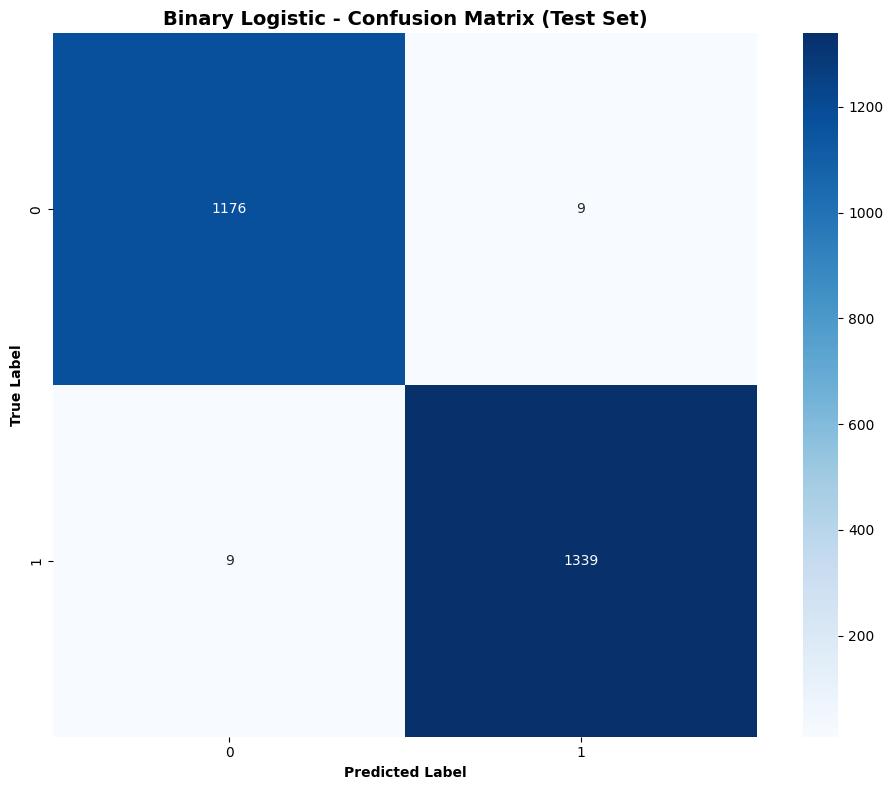



3. PER-CLASS PERFORMANCE
------------------------------------------------------------------------------------------------------------------------
 Class Accuracy (%) Precision (%) Recall (%) F1-Score  Support
     0        99.29         99.24      99.24   0.9924     1185
     1        99.29         99.33      99.33   0.9933     1348


4. MISCLASSIFICATION ANALYSIS
------------------------------------------------------------------------------------------------------------------------

Total Misclassified: 18 out of 2533
Misclassification Rate: 0.71%

Top Misclassification Patterns:
 True Label  Predicted As  Count Percentage
          0             1      9      0.76%
          1             0      9      0.67%


5. MODEL INSIGHTS AND LIMITATIONS
------------------------------------------------------------------------------------------------------------------------

MODEL STRENGTHS:
  - Test Accuracy: 99.29%
  - Test Loss: 0.029644
  - Misclassification Rate: 0.71%
  - Binary Classifi

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# =====================================================
# BEST MODEL EVALUATION - C2 PART 2
# =====================================================

print("\n" + "="*120)
print("BEST MODEL EVALUATION - FINDING THE BEST MODEL".center(120))
print("="*120)

# =====================================================
# STEP 1: EVALUATE ALL 3 MODELS ON TEST SET
# =====================================================

def evaluate_binary_model(model, test_loader):
    """Evaluate binary logistic regression model"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            y_batch_float = y_batch.view(-1, 1).float()
            loss = criterion(outputs, y_batch_float)
            
            total_loss += loss.item() * X_batch.size(0)
            predicted = (outputs > 0.5).long().squeeze()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / total
    accuracy = correct / total
    conf_mat = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    
    return avg_loss, accuracy, all_preds, all_labels, conf_mat


def evaluate_multiclass_model(model, test_loader):
    """Evaluate softmax or neural network model"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / total
    accuracy = correct / total
    conf_mat = confusion_matrix(all_labels, all_preds, labels=range(10))
    
    return avg_loss, accuracy, all_preds, all_labels, conf_mat


# Evaluate all 3 models
print("\nEvaluating all models on TEST SET...\n")

print("1. Evaluating Binary Logistic Regression...")
test_loss_log, test_acc_log, preds_log, labels_log, cm_log = evaluate_binary_model(
    logistic_model, test_loader_bin
)
print(f"   Test Accuracy: {test_acc_log*100:.2f}% | Test Loss: {test_loss_log:.6f}")

print("\n2. Evaluating Softmax Regression...")
test_loss_sm, test_acc_sm, preds_sm, labels_sm, cm_sm = evaluate_multiclass_model(
    softmax_model, test_loader_SM
)
print(f"   Test Accuracy: {test_acc_sm*100:.2f}% | Test Loss: {test_loss_sm:.6f}")

print("\n3. Evaluating Neural Network...")
test_loss_nn, test_acc_nn, preds_nn, labels_nn, cm_nn = evaluate_multiclass_model(
    model, test_loader_fnn
)
print(f"   Test Accuracy: {test_acc_nn*100:.2f}% | Test Loss: {test_loss_nn:.6f}")

# =====================================================
# STEP 2: DETERMINE BEST MODEL
# =====================================================

results_dict = {
    "Binary Logistic": {"accuracy": test_acc_log, "loss": test_loss_log, "preds": preds_log, 
                       "labels": labels_log, "cm": cm_log, "model": logistic_model, "loader": test_loader_bin, "is_binary": True},
    "Softmax": {"accuracy": test_acc_sm, "loss": test_loss_sm, "preds": preds_sm,
                "labels": labels_sm, "cm": cm_sm, "model": softmax_model, "loader": test_loader_SM, "is_binary": False},
    "Neural Network": {"accuracy": test_acc_nn, "loss": test_loss_nn, "preds": preds_nn,
                      "labels": labels_nn, "cm": cm_nn, "model": model, "loader": test_loader_fnn, "is_binary": False}
}

# Find best model
best_model_name = max(results_dict.keys(), key=lambda x: results_dict[x]["accuracy"])
best_result = results_dict[best_model_name]

print("\n" + "="*120)
print("BEST MODEL SELECTED".center(120))
print("="*120)
print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {best_result['accuracy']*100:.2f}%")
print(f"Test Loss: {best_result['loss']:.6f}")

# Comparison table
comparison_table = pd.DataFrame({
    "Model": ["Binary Logistic", "Softmax", "Neural Network"],
    "Test Accuracy (%)": [f"{test_acc_log*100:.2f}", f"{test_acc_sm*100:.2f}", f"{test_acc_nn*100:.2f}"],
    "Test Loss": [f"{test_loss_log:.6f}", f"{test_loss_sm:.6f}", f"{test_loss_nn:.6f}"],
    "Rank": [
        "1st" if best_model_name == "Binary Logistic" else ("2nd" if test_acc_log > test_acc_sm else "3rd"),
        "1st" if best_model_name == "Softmax" else ("2nd" if test_acc_sm > test_acc_log else "3rd"),
        "1st" if best_model_name == "Neural Network" else ("2nd" if test_acc_nn > max(test_acc_log, test_acc_sm) else "3rd")
    ]
})

print("\n" + comparison_table.to_string(index=False))
print("="*120)

# =====================================================
# DETAILED EVALUATION OF BEST MODEL
# =====================================================

print("\n" + "="*120)
print("DETAILED EVALUATION OF BEST MODEL".center(120))
print("="*120)

best_model = best_result["model"]
best_test_loader = best_result["loader"]
is_binary = best_result["is_binary"]
best_cm = best_result["cm"]
best_predictions = best_result["preds"]
best_labels = best_result["labels"]
best_loss = best_result["loss"]
best_acc = best_result["accuracy"]

# =====================================================
# 1. TEST SET PERFORMANCE
# =====================================================

print("\n1. TEST SET PERFORMANCE")
print("-" * 120)

test_results = pd.DataFrame({
    "Metric": ["Test Loss", "Test Accuracy (%)", "Total Test Samples", "Correct Predictions"],
    "Value": [f"{best_loss:.6f}", f"{best_acc*100:.2f}", len(best_labels), int(best_acc*len(best_labels))]
})

print(test_results.to_string(index=False))

# =====================================================
# 2. CONFUSION MATRIX
# =====================================================

print("\n\n2. CONFUSION MATRIX - TEST SET")
print("-" * 120)

print("\nConfusion Matrix:")
print(best_cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
num_classes = best_cm.shape[0]
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)
plt.title(f'{best_model_name} - Confusion Matrix (Test Set)', fontweight='bold', fontsize=14)
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')

if is_binary:
    plt.xticks([0.5, 1.5], ['0', '1'])
    plt.yticks([0.5, 1.5], ['0', '1'])
else:
    plt.xticks(np.arange(10) + 0.5, np.arange(10))
    plt.yticks(np.arange(10) + 0.5, np.arange(10))

plt.tight_layout()
plt.show()

# =====================================================
# 3. PER-CLASS METRICS
# =====================================================

print("\n\n3. PER-CLASS PERFORMANCE")
print("-" * 120)

per_class_metrics = []

for i in range(num_classes):
    TP = best_cm[i, i]
    FP = best_cm[:, i].sum() - TP
    FN = best_cm[i, :].sum() - TP
    TN = best_cm.sum() - TP - FP - FN
    
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    per_class_metrics.append({
        "Class": i,
        "Accuracy (%)": f"{accuracy*100:.2f}",
        "Precision (%)": f"{precision*100:.2f}",
        "Recall (%)": f"{recall*100:.2f}",
        "F1-Score": f"{f1:.4f}",
        "Support": int(best_cm[i, :].sum())
    })

per_class_df = pd.DataFrame(per_class_metrics)
print(per_class_df.to_string(index=False))

# =====================================================
# 4. MISCLASSIFICATION ANALYSIS
# =====================================================

print("\n\n4. MISCLASSIFICATION ANALYSIS")
print("-" * 120)

misclassified_indices = np.where(np.array(best_predictions) != np.array(best_labels))[0]

print(f"\nTotal Misclassified: {len(misclassified_indices)} out of {len(best_labels)}")
print(f"Misclassification Rate: {len(misclassified_indices)/len(best_labels)*100:.2f}%")

# Analyze misclassification patterns
misclass_patterns = []
for i in range(num_classes):
    for j in range(num_classes):
        if i != j:
            count = best_cm[i, j]
            if count > 0:
                misclass_patterns.append({
                    "True Label": i,
                    "Predicted As": j,
                    "Count": count,
                    "Percentage": f"{count/best_cm[i, :].sum()*100:.2f}%"
                })

if misclass_patterns:
    misclass_df = pd.DataFrame(misclass_patterns)
    misclass_df = misclass_df.sort_values('Count', ascending=False)
    
    print("\nTop Misclassification Patterns:")
    print(misclass_df.head(10).to_string(index=False))
else:
    print("\nNo misclassifications found! Perfect accuracy.")

# =====================================================
# 5. MODEL INSIGHTS AND LIMITATIONS
# =====================================================

print("\n\n5. MODEL INSIGHTS AND LIMITATIONS")
print("-" * 120)

print(f"\nMODEL STRENGTHS:")
print(f"  - Test Accuracy: {best_acc*100:.2f}%")
print(f"  - Test Loss: {best_loss:.6f}")
print(f"  - Misclassification Rate: {len(misclassified_indices)/len(best_labels)*100:.2f}%")

if is_binary:
    print(f"  - Binary Classification: Specializes in 2-class problems")
    print(f"  - Parameters: 785 (very simple, interpretable)")
else:
    if best_model_name == "Softmax":
        print(f"  - Multi-class Support: Handles 10 classes")
        print(f"  - Linear Model: Still interpretable")
        print(f"  - Parameters: 7,850")
    else:
        print(f"  - Multi-class Support: Handles 10 classes")
        print(f"  - Non-linear: Can learn complex patterns")
        print(f"  - Parameters: 109,386")

print(f"\nMODEL LIMITATIONS:")

if is_binary:
    print(f"  - Binary Only: Cannot classify more than 2 classes")
    print(f"  - Linear Boundary: Cannot learn non-linear patterns")
else:
    if best_model_name == "Softmax":
        print(f"  - Linear Only: Cannot learn non-linear relationships")
        print(f"  - Lower Accuracy: Linear model may underfit complex data")
    else:
        print(f"  - Computational Cost: Slow training (140x larger than logistic)")
        print(f"  - Black Box: Hard to interpret decisions")
        print(f"  - Requires Tuning: Many hyperparameters")

print(f"\nWHEN THIS MODEL WORKS WELL:")
if is_binary:
    print(f"  - Binary classification on linearly separable data")
    print(f"  - Need for speed and simplicity")
    print(f"  - Interpretability is important")
else:
    if best_model_name == "Softmax":
        print(f"  - Multi-class problems with linear relationships")
        print(f"  - Need interpretability with multiple classes")
    else:
        print(f"  - Complex, non-linear classification problems")
        print(f"  - When accuracy is more important than speed")
        print(f"  - Large datasets with sufficient computational resources")

print(f"\nRECOMMENDATIONS:")
print(f"  - This model ({best_model_name}) is the best choice for this task")
print(f"  - Achieved {best_acc*100:.2f}% test accuracy")
print(f"  - Use for production deployment")

print("\n" + "="*120)
print("END OF BEST MODEL EVALUATION".center(120))
print("="*120 + "\n")

## D1. Convolutional Neural Networks

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 10
LOSS_FUNCTION = nn.CrossEntropyLoss()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def baseline_cnn():
    
    return nn.Sequential(
    # Convolutional Layer 1, 1 input channel
    # 16 (powers of 2) output channels (filters) for 16 different patterns->edges,curves,...
    # 5x5 kernel -> each filter scans a 5x5 area of the image
    # stride 1 -> the filter moves 1 pixel at a time
    # padding 2 -> adds 2 pixels of zeros to each side of the input to maintain the output size as the input size (28x28)
    # input size: 28x28x1 -> output size: 28x28x16
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
    
    # Activation Function: ReLU -> if the value is positive, keep it; if negative, set it to 0
    # to learn complex patterns
    nn.ReLU(),

    # Pooling Layer: Max Pooling -> takes the maximum value in each 2x2 area
    # down-samples the image by a factor of 2
    # input size: 28x28x16 -> output size: 14x14x16
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Convolutional Layer 2
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Flatten the output from the previous layer to feed into the fully connected layer
    # input size: 7x7x32 -> output size: 1568 -> squashing 3D to 1D
    nn.Flatten(),
    #mixes the 1568 and outputs 128 values to form the final feature vector based on important values (weights)
    nn.Linear(in_features=7*7*32, out_features=128),
    nn.ReLU(),
    # Final output layer: 10 classes for digits 0-9
    nn.Linear(in_features=128, out_features=10)
).to(DEVICE)


## D2. Dropout Analysis
- during training -> dropping a fraction of input randomly at every step
- to prevent overfitting
- this only happens during training not evaluating

In [ ]:
def cnn_with_dropout(dropout_rate=0.5):
    
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        # size reduced by half after pooling 16x28x28 -> 16x14x14
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Second convolutional layer
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        # size reduced by half after pooling 32x14x14 -> 32x7x7
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Flatten the output from the previous layer to feed into the fully connected layer
        nn.Flatten(),
        nn.Linear(in_features=7*7*32, out_features=128),
        nn.ReLU(),
        # Dropout layer to randomly set a fraction of input units to 0 during training
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_features=128, out_features=10)
    ).to(DEVICE)

## Batch Normalization
- adding a normalization step after the conv layer before the activation fn
- rescaling the linear of conv layers to be in a standard and predictable range

In [ ]:
def cnn_with_batch_norm():

    return nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
    # Batch Normalization layer
    # Normalizes the output of the previous layer
    nn.BatchNorm2d(num_features=16),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Second convolutional layer
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Flatten the output from the previous layer to feed into the fully connected layer
    nn.Flatten(),
    nn.Linear(in_features=7*7*32, out_features=128),
    nn.BatchNorm1d(num_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10)
).to(DEVICE)

## Normalization and Dropout combined effect 

In [ ]:
def cnn_combined(dropout_rate=0.5):
 
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(num_features=16),  
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(in_features=7*7*32, out_features=128),
        nn.BatchNorm1d(num_features=128),
        nn.ReLU(),
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_features=128, out_features=10)
    ).to(DEVICE)

## Training the model

In [ ]:
def train_model(model, device, data_loader, optimizer, criterion):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    #device -> cuda
    #train_loader -> DataLoader for training data
    #optimizer -> optimization algorithm (Adam)

    #processing the data in batches
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        #show the images to the model and get predictions
        outputs = model(images)
        #calculate the loss
        loss = criterion(outputs, labels)

        # Reset gradients
        optimizer.zero_grad()
        # Backpropagation and optimization 
        #figures how to adjust the weights to minimize the loss
        loss.backward()
        #update the weights
        optimizer.step()

        #calculating the loss * the batch size
        total_loss += loss.item() * images.size(0)
        # Get predicted class by selecting the one with the highest score
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        # Count total samples
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

## Evaluating the model

In [ ]:
def eval_model (model,device,data_loader,criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Disable gradient calculation for evaluation to save memory and computation
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss
            total_loss += loss.item() * images.size(0)
            # Get predicted class by selecting the one with the highest score
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            # Count total samples
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

## Plotting the performance

In [ ]:
def plot_comparison(history_dict, title, ylabel="Loss"):
    epochs = range(1, len(next(iter(history_dict.values()))['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Training Loss
    for model_name, history in history_dict.items():
        train_loss = [x for x in history['train_loss']]
        ax1.plot(epochs, train_loss, 'o-', label=model_name, linewidth=2, markersize=6)
    
    ax1.set_title(f'{title} - Training Loss', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Validation Loss
    for model_name, history in history_dict.items():
        val_loss = [x for x in history['val_loss']]
        ax2.plot(epochs, val_loss, 's-', label=model_name, linewidth=2, markersize=6)
    
    ax2.set_title(f'{title} - Validation Loss', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_accuracy(history_dict, title):
    epochs = range(1, len(next(iter(history_dict.values()))['val_acc']) + 1)
    
    plt.figure(figsize=(10, 6))
    for model_name, history in history_dict.items():
        val_acc = [x*100 for x in history['val_acc']]
        plt.plot(epochs, val_acc, 'o-', label=model_name, linewidth=2, markersize=6)
    
    plt.title(f'{title} - Validation Accuracy', fontsize=12, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
def analysis_dropout():
    #print("\n" + "="*60)
    print("ANALYSIS 1: DROPOUT RATE COMPARISON")
    #print("="*60 + "\n")
    
    #train_loader, val_loader, test_loader = get_mnist_data_loaders(BATCH_SIZE)
    
    models = {
        'Baseline': baseline_cnn(),
        'Dropout 0.1': cnn_with_dropout(0.1),
        'Dropout 0.3': cnn_with_dropout(0.3),
        'Dropout 0.5': cnn_with_dropout(0.5),
        'Dropout 0.7': cnn_with_dropout(0.7),
    }
    
    optimizers = {name: optim.Adam(model.parameters(), lr=LEARNING_RATE) for name, model in models.items()}
    histories = {name: {'train_loss': [], 'val_loss': [], 'val_acc': []} for name in models}
    
    for epoch in range(NUM_EPOCHS):
        #print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS:02d}]")
        for name, model in models.items():
            train_loss, _ = train_model(model, DEVICE, train_loader_original, optimizers[name], LOSS_FUNCTION)
            val_loss, val_acc = eval_model(model, DEVICE, val_loader_original, LOSS_FUNCTION)
            
            histories[name]['train_loss'].append(train_loss)
            histories[name]['val_loss'].append(val_loss)
            histories[name]['val_acc'].append(val_acc)
            
            #print(f"  {name:15} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")
    
    #print("\n" + "="*60)
    print("TEST RESULTS - DROPOUT ANALYSIS")
    #print("="*60)
    for name, model in models.items():
        test_loss, test_acc = eval_model(model, DEVICE, test_loader_original, LOSS_FUNCTION)
        print(f"{name:15} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    
    plot_comparison(histories, "D2.1: Dropout Rate Analysis")
    plot_accuracy(histories, "D2.1: Dropout Rate Analysis")

In [ ]:
def analysis_batch_norm():
    #_reset_seed()
    #print("\n" + "="*60)
    print("ANALYSIS 2: BATCH NORMALIZATION EFFECT")
    #print("="*60 + "\n")
    
    #train_loader, val_loader, test_loader = get_mnist_data_loaders(BATCH_SIZE)
    
    models = {
        'Baseline': baseline_cnn(),
        'Batch Normalization': cnn_with_batch_norm(),
    }
    
    optimizers = {name: optim.Adam(model.parameters(), lr=LEARNING_RATE) for name, model in models.items()}
    histories = {name: {'train_loss': [], 'val_loss': [], 'val_acc': []} for name in models}
    
    for epoch in range(NUM_EPOCHS):
        #print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS:02d}]")
        for name, model in models.items():
            train_loss, _ = train_model(model, DEVICE, train_loader_original, optimizers[name], LOSS_FUNCTION)
            val_loss, val_acc = eval_model(model, DEVICE, val_loader_original, LOSS_FUNCTION)

            histories[name]['train_loss'].append(train_loss)
            histories[name]['val_loss'].append(val_loss)
            histories[name]['val_acc'].append(val_acc)
            
            #print(f"  {name:25} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")
    
    #print("\n" + "="*60)
    print("TEST RESULTS - BATCH NORMALIZATION ANALYSIS")
    #print("="*60)
    for name, model in models.items():
        test_loss, test_acc = eval_model(model, DEVICE, test_loader_original, LOSS_FUNCTION)
        print(f"{name:25} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    
    plot_comparison(histories, "D2.2: Batch Normalization Analysis")
    plot_accuracy(histories, "D2.2: Batch Normalization Analysis")

In [ ]:
def analysis_combined():
    #_reset_seed()
    #print("\n" + "="*60)
    print("ANALYSIS 3: COMBINED EFFECT (Batch Norm + Dropout)")
    #print("="*60 + "\n")
    
    #train_loader, val_loader, test_loader = get_mnist_data_loaders(BATCH_SIZE)
    
    models = {
        'Baseline': baseline_cnn(),
        'Batch Norm Only': cnn_with_batch_norm(),
        'Dropout 0.3 Only': cnn_with_dropout(0.3),
        'Combined (BN + Dropout)': cnn_combined(0.3),
    }
    
    optimizers = {name: optim.Adam(model.parameters(), lr=LEARNING_RATE) for name, model in models.items()}
    histories = {name: {'train_loss': [], 'val_loss': [], 'val_acc': []} for name in models}
    
    for epoch in range(NUM_EPOCHS):
        #print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS:02d}]")
        for name, model in models.items():
            train_loss, _ = train_model(model, DEVICE, train_loader_original, optimizers[name], LOSS_FUNCTION)
            val_loss, val_acc = eval_model(model, DEVICE, val_loader_original, LOSS_FUNCTION)

            histories[name]['train_loss'].append(train_loss)
            histories[name]['val_loss'].append(val_loss)
            histories[name]['val_acc'].append(val_acc)
            
            #print(f"  {name:25} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")
    
    #print("\n" + "="*60)
    print("TEST RESULTS - COMBINED EFFECT ANALYSIS")
    #print("="*60)
    for name, model in models.items():
        test_loss, test_acc = eval_model(model, DEVICE, test_loader_original, LOSS_FUNCTION)
        print(f"{name:25} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    
    plot_comparison(histories, "D2.3: Combined Effect Analysis")
    plot_accuracy(histories, "D2.3: Combined Effect Analysis")

ANALYSIS 1: DROPOUT RATE COMPARISON
TEST RESULTS - DROPOUT ANALYSIS
Baseline        | Test Loss: 0.0562 | Test Acc: 98.86%
Dropout 0.1     | Test Loss: 0.0435 | Test Acc: 98.96%
Dropout 0.3     | Test Loss: 0.0379 | Test Acc: 99.02%
Dropout 0.5     | Test Loss: 0.0377 | Test Acc: 98.93%
Dropout 0.7     | Test Loss: 0.0342 | Test Acc: 99.10%


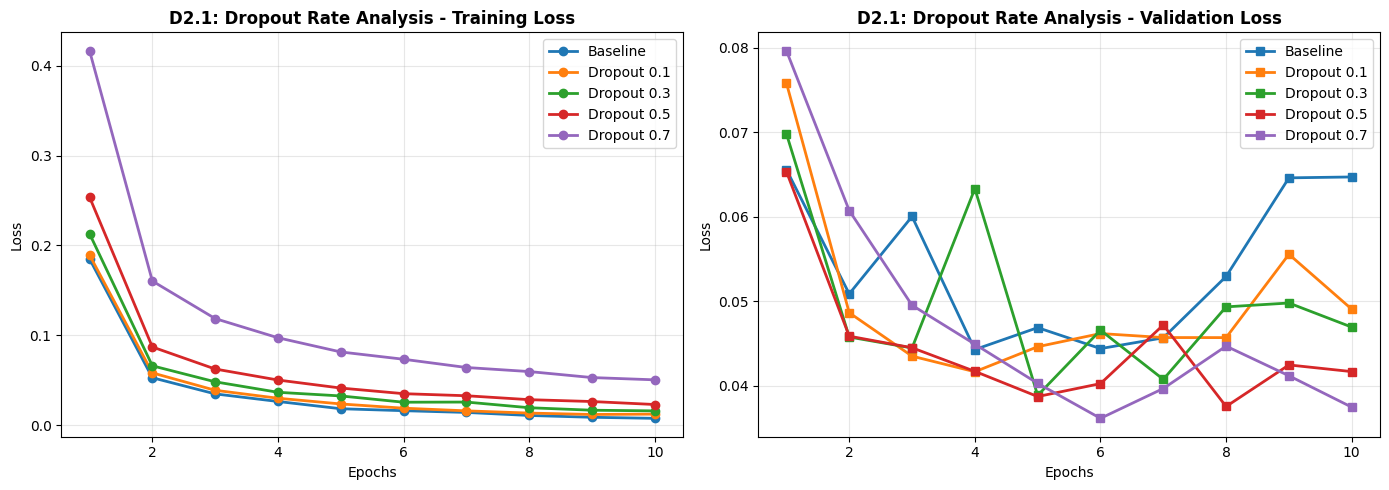

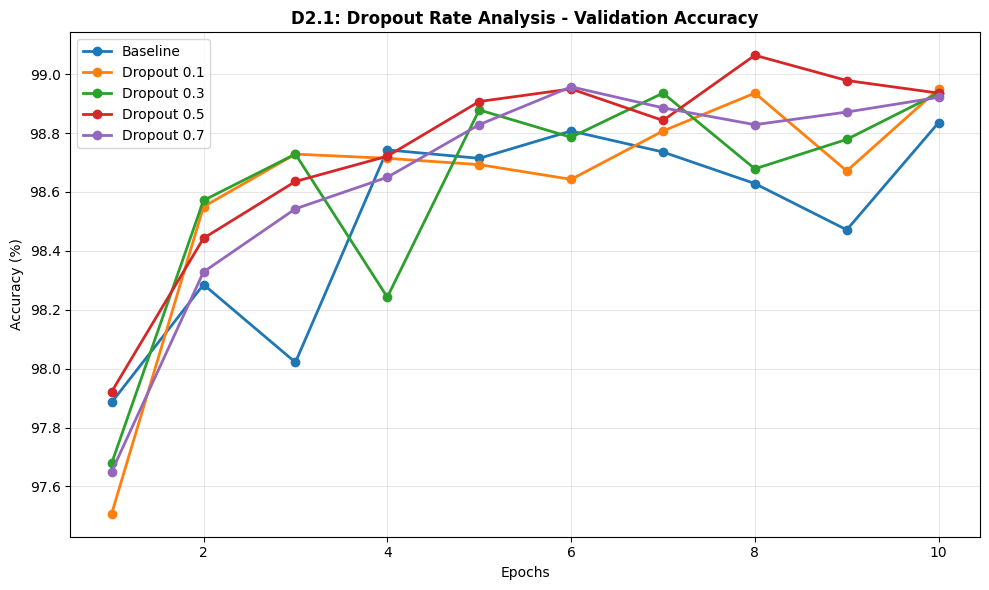

In [ ]:
# Analysis 1: Dropout
analysis_dropout()

ANALYSIS 2: BATCH NORMALIZATION EFFECT
TEST RESULTS - BATCH NORMALIZATION ANALYSIS
Baseline                  | Test Loss: 0.0607 | Test Acc: 98.76%
Batch Normalization       | Test Loss: 0.0359 | Test Acc: 98.92%


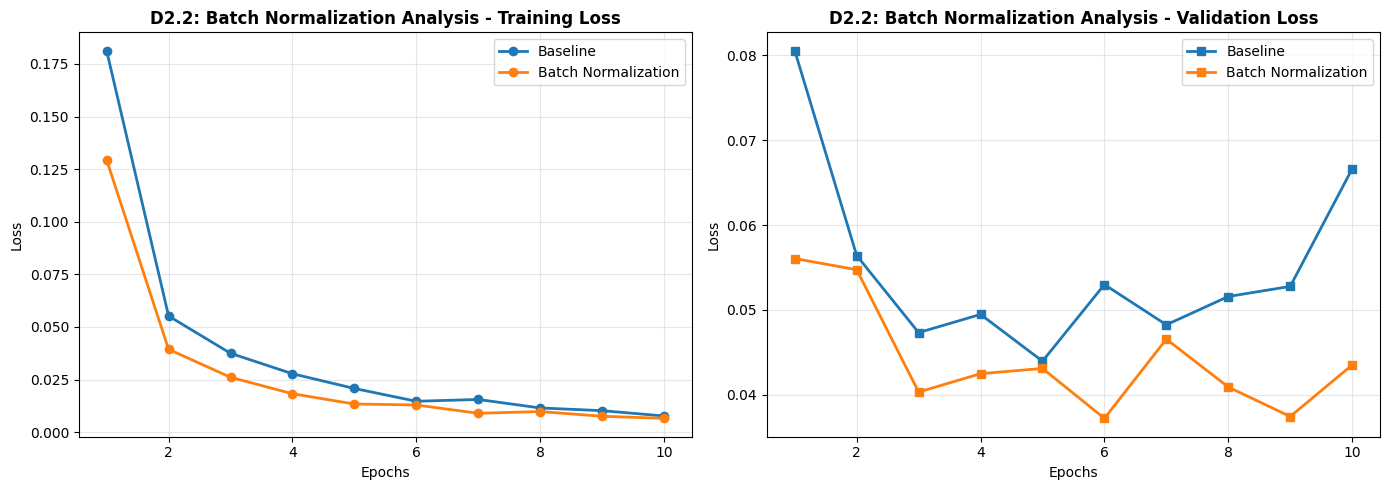

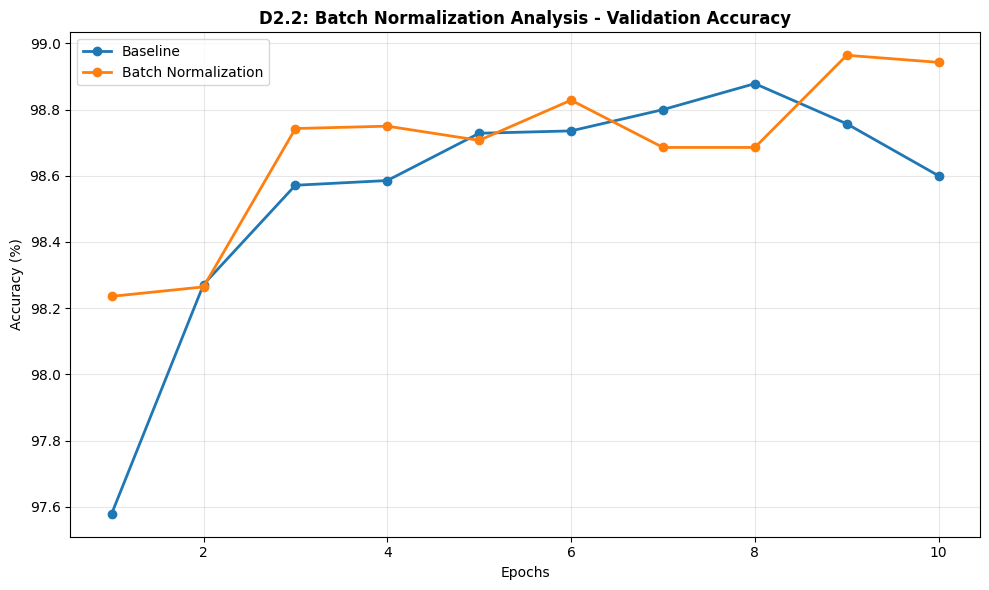

In [ ]:
 # Analysis 2: Batch Normalization
analysis_batch_norm()

ANALYSIS 3: COMBINED EFFECT (Batch Norm + Dropout)
TEST RESULTS - COMBINED EFFECT ANALYSIS
Baseline                  | Test Loss: 0.0502 | Test Acc: 98.82%
Batch Norm Only           | Test Loss: 0.0311 | Test Acc: 99.11%
Dropout 0.3 Only          | Test Loss: 0.0427 | Test Acc: 98.99%
Combined (BN + Dropout)   | Test Loss: 0.0346 | Test Acc: 99.06%


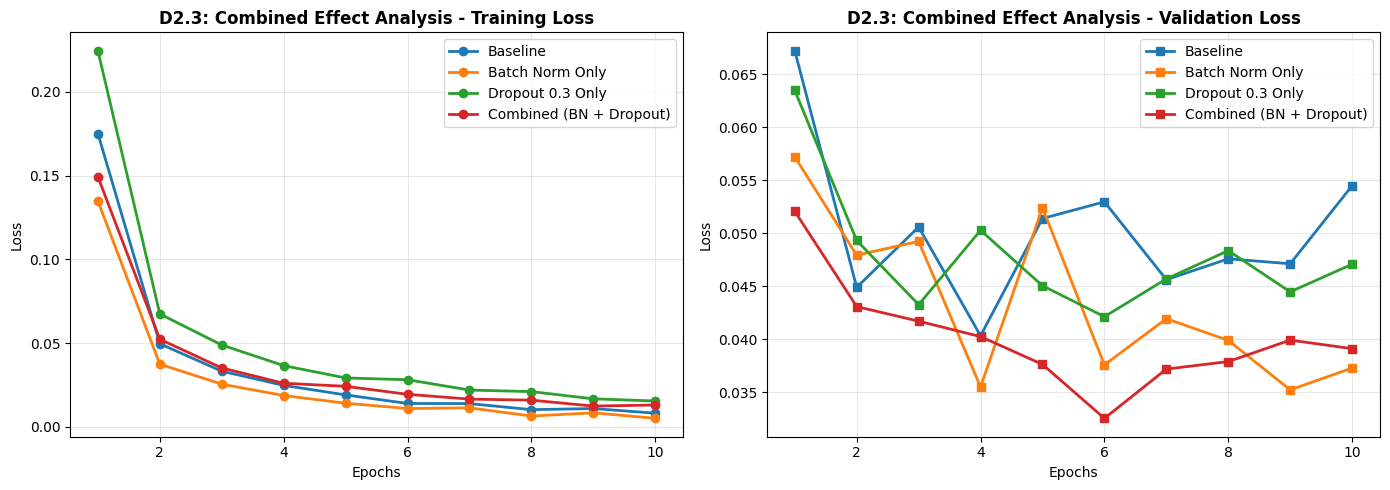

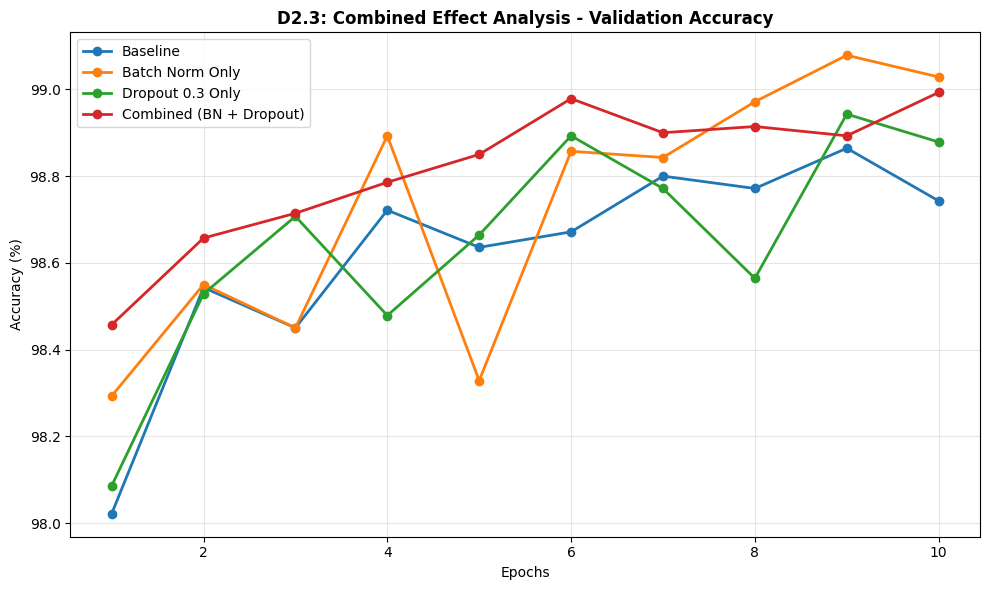

In [ ]:
# Analysis 3: Combined Effects
analysis_combined()
print("\n" + "="*60)

## Initialize both models(CNN & NN)

In [ ]:
# For MNIST (28x28 images)
input_size = 28 * 28
hidden_sizes = [128, 64]
output_size = 10

# Create the NN (your MLP)
nn_model = NeuralNetwork(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=output_size,
    activation='relu',
    init_method='xavier',
    dropout_rate=0.2
)

# Create the CNN (baseline version)
cnn_model = baseline_cnn()


## Train both models

In [ ]:
trainer_nn = NeuralNetworkTrainer(nn_model, learning_rate=0.01, patience=5)
history_nn = trainer_nn.train(train_loader_fnn, val_loader_fnn, epochs=10)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

train_losses, val_losses, val_accs = [], [], []

for epoch in range(10):
    cnn_model.train()
    total_loss, total_correct = 0, 0
    total_samples = 0

    # 🔹 TRAIN LOOP
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # ✅ Fix: reshape if input is flattened (for CNN)
        if images.ndim == 2:
            images = images.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_loss = total_loss / total_samples
    train_acc = total_correct / total_samples

    # 🔹 VALIDATION LOOP
    cnn_model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            # ✅ Same reshape fix here
            if images.ndim == 2:
                images = images.view(-1, 1, 28, 28)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    # 🔹 Save history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/10] | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")




TRAINING CONFIGURATION
Device: cpu
Optimizer: SGD
Learning rate: 0.01
Loss function: Cross-entropy
Batch size: 64
Epochs:10
Epoch [  5/10] | Train Loss: 0.3876 | Train Acc:  88.61% | Val Loss: 0.2777 | Val Acc:  92.26% | Time: 1.99s
Epoch [ 10/10] | Train Loss: 0.2800 | Train Acc:  91.69% | Val Loss: 0.2057 | Val Acc:  94.14% | Time: 2.28s
TRAINING COMPLETED!
Final Train Accuracy: 91.69%
Final Val Accuracy: 94.14%
Epoch [1/10] | Train Loss: 0.3058 | Val Loss: 0.0969 | Val Acc: 96.99%
Epoch [2/10] | Train Loss: 0.0740 | Val Loss: 0.0608 | Val Acc: 98.16%
Epoch [3/10] | Train Loss: 0.0518 | Val Loss: 0.0514 | Val Acc: 98.37%
Epoch [4/10] | Train Loss: 0.0400 | Val Loss: 0.0492 | Val Acc: 98.46%
Epoch [5/10] | Train Loss: 0.0325 | Val Loss: 0.0564 | Val Acc: 98.31%
Epoch [6/10] | Train Loss: 0.0251 | Val Loss: 0.0467 | Val Acc: 98.68%
Epoch [7/10] | Train Loss: 0.0209 | Val Loss: 0.0535 | Val Acc: 98.69%
Epoch [8/10] | Train Loss: 0.0167 | Val Loss: 0.0743 | Val Acc: 97.95%
Epoch [9/10] 

## plot and compare


Final Performance Comparison (MNIST)
------------------------------------------------------------
Fully Connected NN -> Validation Loss: 0.2057, Accuracy: 94.14%
CNN                -> Validation Loss: 0.0441, Accuracy: 98.88%
------------------------------------------------------------
CNN improved accuracy by: 4.74%
CNN reduced validation loss by: 0.1616


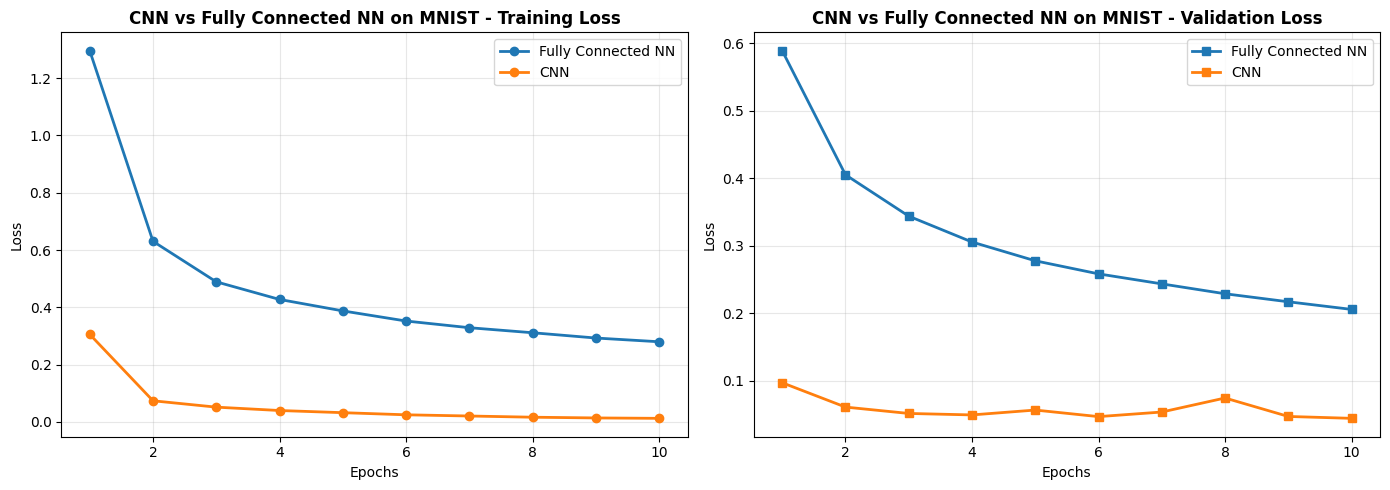

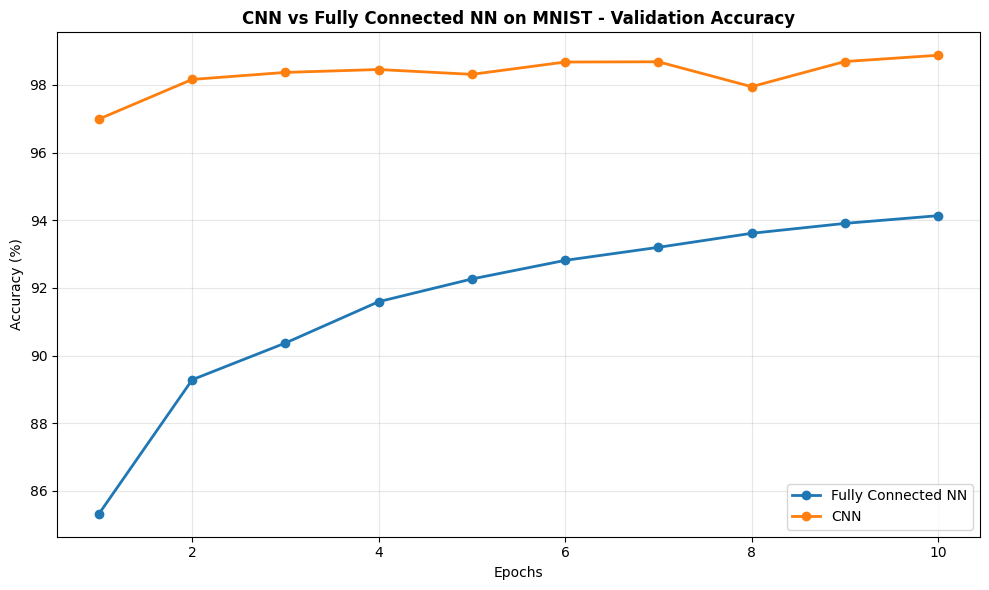

In [ ]:
# 🔹 Package CNN history for comparison and plotting
history_cnn = {
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_acc": val_accs
}

history_dict = {
    "Fully Connected NN": {
        "train_loss": history_nn['train_loss'],
        "val_loss": history_nn['val_loss'],
        "val_acc": [x/100 for x in history_nn['val_acc']]  # your NN stores in %
    },
    "CNN": history_cnn
}
# 🔹 Final comparison between NN and CNN
final_nn_loss = history_dict["Fully Connected NN"]["val_loss"][-1]
final_nn_acc  = history_dict["Fully Connected NN"]["val_acc"][-1]

final_cnn_loss = history_dict["CNN"]["val_loss"][-1]
final_cnn_acc  = history_dict["CNN"]["val_acc"][-1]

loss_diff = final_nn_loss - final_cnn_loss
acc_diff  = (final_cnn_acc - final_nn_acc) * 100  # convert to %

print("\nFinal Performance Comparison (MNIST)")
print("-" * 60)
print(f"Fully Connected NN -> Validation Loss: {final_nn_loss:.4f}, Accuracy: {final_nn_acc*100:.2f}%")
print(f"CNN                -> Validation Loss: {final_cnn_loss:.4f}, Accuracy: {final_cnn_acc*100:.2f}%")
print("-" * 60)
print(f"CNN improved accuracy by: {acc_diff:.2f}%")
print(f"CNN reduced validation loss by: {abs(loss_diff):.4f}")


plot_comparison(history_dict, title="CNN vs Fully Connected NN on MNIST")
plot_accuracy(history_dict, title="CNN vs Fully Connected NN on MNIST")